# Random Forest Forecasting of Volatility

In this notebook we complete the tree-based forecasting models for the volatility of the stock data, by implementing a random forest predictor on the time series.

### Summary of the Technique

We have a time series $\mathbf{V}_t$ of observed volatilities:

$$
V_t = \text{standard deviation of log returns on } [t-30, t]
$$
and we want to forecast $\mathbf{V}_t$ using a `RandomForestRegressor`. 

The `RandomForestRegressor` expects array-like inputs `X_train` and `y_train` to fit the regression. However, our time series only has $\mathbf{V}_t$ which is the `y` part. So we need to make the `X` part out of the series $\mathbf{V}_t$. 

To make `X_train`, we need to choose a rolling window size, and then we make `X_train` be the 2D array, where each row corresponds to a window from $\mathbf{V}_t$. For example, if we chose `window = 3`, then : 

```python
#               y_{t-1}  y_{t-2}  y_{t-3}
X_train = [  
                [1.1,   2.0,    3.2],
                [5.3,   1.1,    2.0],
                ...
]
```
where each row corresponds to `t=1, t=2, t=3` etc. In practice we will have to remove the first `window_size` rows to avoid `NaN` values. Once we have made `X_train` and `y_train`, we can then fit `RandomForestRegressor` as usual and then predict on the out-of-sample values. To choose the window size, we will implement a $3$-fold cross-validation for each stock and determine which window size performs best on the training set. 

***
## Preprocessing

### Packages

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np 

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style
set_style("whitegrid")

### Data Processing

Loading the data sets:

In [2]:
tech = pd.read_csv("../data/tech_data.csv", parse_dates=True)
biotech = pd.read_csv("../data/biotech_data.csv", parse_dates=True)
healthcare = pd.read_csv("../data/healthcare_data.csv", parse_dates=True)
industrial = pd.read_csv("../data/industrial_data.csv", parse_dates=True)

Make a new column `returns` for the daily returns and then `volatility` for the volatility.   

In [3]:
## get the tickers
tech_tickers = list(tech.columns[1:])
biotech_tickers = list(biotech.columns[1:])
healthcare_tickers = list(healthcare.columns[1:])
industrial_tickers = list(industrial.columns[1:])

for i in range(5):
    ## tech stocks
    tech[f"{tech_tickers[i]}_returns"] = np.log(tech[tech_tickers[i]]) - np.log(tech[tech_tickers[i]].shift(-1))
    tech[f"{tech_tickers[i]}_volatility"] = tech[f"{tech_tickers[i]}_returns"].rolling(30).std()

    ## biotech stocks
    biotech[f"{biotech_tickers[i]}_returns"] = np.log(biotech[biotech_tickers[i]]) - np.log(biotech[biotech_tickers[i]].shift(-1))
    biotech[f"{biotech_tickers[i]}_volatility"] = biotech[f"{biotech_tickers[i]}_returns"].rolling(30).std()

    ## healthcare stocks
    healthcare[f"{healthcare_tickers[i]}_returns"] = np.log(healthcare[healthcare_tickers[i]]) - np.log(healthcare[healthcare_tickers[i]].shift(-1))
    healthcare[f"{healthcare_tickers[i]}_volatility"] = healthcare[f"{healthcare_tickers[i]}_returns"].rolling(30).std()

    ## industrial stocks
    industrial[f"{industrial_tickers[i]}_returns"] = np.log(industrial[industrial_tickers[i]]) - np.log(industrial[industrial_tickers[i]].shift(-1))
    industrial[f"{industrial_tickers[i]}_volatility"] = industrial[f"{industrial_tickers[i]}_returns"].rolling(30).std()


## remove missing values
tech.dropna(inplace=True)
biotech.dropna(inplace=True)
healthcare.dropna(inplace=True)
industrial.dropna(inplace=True)

## reset the index
tech.reset_index(inplace=True, drop=True)
biotech.reset_index(inplace=True, drop=True)
healthcare.reset_index(inplace=True, drop=True)
industrial.reset_index(inplace=True, drop=True)

### Train-Test Split

Here we make the train-test split for the data. We will hold back approximately 20% of the data for the test. 

In [4]:
## find the index that makes the 80-20 split
splitting_index = int(len(tech.index)*0.8)

## make the train/test splits
tech_train, tech_test = tech[:splitting_index].copy(), tech[splitting_index:].copy()
biotech_train, biotech_test = biotech[:splitting_index].copy(), biotech[splitting_index:].copy()
healthcare_train, healthcare_test = healthcare[:splitting_index].copy(), healthcare[splitting_index:].copy()
industrial_train, industrial_test = industrial[:splitting_index].copy(), industrial[splitting_index:].copy()

***
## Random Forest Fitting

We will fit a random forest regressor to the returns. To determine the size of the rolling window, we cross validate with different window sizes and see which performs the best. 

In [5]:
## define the window sizes to be cross validated
window_sizes = [5,10,15,30,60]

## find the prediction horizon
horizon = len(tech_test.index)

We will perform a $3$-fold cross validation to determine which window size is best on the training data. Each will forecast $649$ days, which is the prediction horizon. 

In [6]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Create the $3$-fold object. 

In [7]:
kfold = TimeSeriesSplit(n_splits=3,
                        test_size=horizon)

Perform the cross validation for the tech stocks:

In [8]:
from Volatility_Random_Forest import VolatilityRandomForest

## empty dataframe to hold the average MSES for each stock
tech_results = pd.DataFrame(index=window_sizes, columns=tech_tickers)

for stock in tech_tickers:
    print(f"working on {stock}")

    ## make empty array for the mses
    mses = {k:[0]*3 for k in window_sizes}

    ## this keeps track of which split we are on
    i = 0

    ## iterate through the splits
    for train_index, test_index in kfold.split(tech_train[f'{stock}_volatility']):
            
        train = tech_train.loc[train_index, f'{stock}_volatility']
        holdout = tech_train.loc[test_index, f'{stock}_volatility']

        # for each window we make a new model
        for window in window_sizes:
            print(f"\tworking on window {window}")

            ## make an X_train by collecting rolling windows of size window
            ## remove the first window rows because they contain None values
            X_train = np.concatenate([train.shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
            ## the values to be trained against
            y_train = train.values[window:]

            ## create random forest object and fit
            rf = VolatilityRandomForest(max_depth=5)
            rf.fit(X_train, y_train)

            ## make the holdout set with the same window
            X_holdout = np.concatenate([holdout.shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
            ## make prediction on the holdout set
            pred = rf.predict(X=X_holdout, n_windows=window)

            ## add the mean square error to the array
            mses[window][i] = mean_squared_error(tech_train.loc[test_index, f'{stock}_volatility'].values[window:], 
                                                 pred)
        
        i += 1
    
    ## add the average mse to the dataframe
    for window in mses.keys():
        tech_results.loc[window, stock] = np.mean(mses[window])

working on AAPL
	working on window 5
	working on window 10
	working on window 15
	working on window 30
	working on window 60
	working on window 5
	working on window 10
	working on window 15
	working on window 30
	working on window 60
	working on window 5
	working on window 10
	working on window 15
	working on window 30
	working on window 60
working on AMZN
	working on window 5
	working on window 10
	working on window 15
	working on window 30
	working on window 60
	working on window 5
	working on window 10
	working on window 15
	working on window 30
	working on window 60
	working on window 5
	working on window 10
	working on window 15
	working on window 30
	working on window 60
working on GOOGL
	working on window 5
	working on window 10
	working on window 15
	working on window 30
	working on window 60
	working on window 5
	working on window 10
	working on window 15
	working on window 30
	working on window 60
	working on window 5
	working on window 10
	working on window 15
	working on wi

In [9]:
tech_results

,AAPL,AMZN,GOOGL,MSFT,NVDA
5,0.000071,0.000081,0.000056,0.000068,0.000174
10,0.000062,0.000108,0.000053,0.0001,0.000144
15,0.00008,0.000118,0.000062,0.000091,0.000128
30,0.000079,0.000073,0.000084,0.000078,0.000192
60,0.000142,0.000096,0.000041,0.000081,0.000106


In [10]:
for tick in tech_results.columns:
    print(f"{tick} has the best window size of", tech_results.index[np.argmin(tech_results[f'{tick}'])])

AAPL has the best window size of 10
AMZN has the best window size of 30
GOOGL has the best window size of 60
MSFT has the best window size of 5
NVDA has the best window size of 60


We perform the same analysis for all of the industries. 

In [58]:
## BIOTECH STOCKS
biotech_results = pd.DataFrame(index=window_sizes, columns=biotech_tickers)

for stock in biotech_tickers:
    mses = {k:[0]*5 for k in window_sizes}
    i = 0
    for train_index, test_index in kfold.split(biotech_train[f'{stock}_volatility']):
        train = biotech_train.loc[train_index, f'{stock}_volatility']
        holdout = biotech_train.loc[test_index, f'{stock}_volatility']
        for window in window_sizes:
            X_train = np.concatenate([train.shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
            y_train = train.values[window:]
            rf = RandomForestRegressor(max_depth=5)
            rf.fit(X_train, y_train)
            X_holdout = np.concatenate([holdout.shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
            pred = rf.predict(X_holdout)
            mses[window][i] = mean_squared_error(biotech_train.loc[test_index, f'{stock}_volatility'].values[window:], 
                                                 pred)
        i += 1
    for window in mses.keys():
        biotech_results.loc[window, stock] = np.mean(mses[window])
        
for tick in biotech_results.columns:
    print(f"{tick} has the best window size of", biotech_results.index[np.argmin(biotech_results[f'{tick}'])])

JNJ has the best window size of 5
LLY has the best window size of 5
MRK has the best window size of 5
NVO has the best window size of 30
RHHBY has the best window size of 10


In [59]:
## HEALTHCARE STOCKS
healthcare_results = pd.DataFrame(index=window_sizes, columns=healthcare_tickers)

for stock in healthcare_tickers:
    mses = {k:[0]*5 for k in window_sizes}
    i = 0
    for train_index, test_index in kfold.split(healthcare_train[f'{stock}_volatility']):
        train = healthcare_train.loc[train_index, f'{stock}_volatility']
        holdout = healthcare_train.loc[test_index, f'{stock}_volatility']
        for window in window_sizes:
            X_train = np.concatenate([train.shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
            y_train = train.values[window:]
            rf = RandomForestRegressor(max_depth=5)
            rf.fit(X_train, y_train)
            X_holdout = np.concatenate([holdout.shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
            pred = rf.predict(X_holdout)
            mses[window][i] = mean_squared_error(healthcare_train.loc[test_index, f'{stock}_volatility'].values[window:], 
                                                 pred)
        i += 1
    for window in mses.keys():
        healthcare_results.loc[window, stock] = np.mean(mses[window])

for tick in healthcare_results.columns:
    print(f"{tick} has the best window size of", healthcare_results.index[np.argmin(healthcare_results[f'{tick}'])])

AMGN has the best window size of 5
CVS has the best window size of 5
ELV has the best window size of 10
PFE has the best window size of 5
UNH has the best window size of 5


In [60]:
## INDUSTRIAL STOCKS
industrial_results = pd.DataFrame(index=window_sizes, columns=industrial_tickers)

for stock in industrial_tickers:
    mses = {k:[0]*5 for k in window_sizes}
    i = 0
    for train_index, test_index in kfold.split(industrial_train[f'{stock}_volatility']):
        train = industrial_train.loc[train_index, f'{stock}_volatility']
        holdout = industrial_train.loc[test_index, f'{stock}_volatility']
        for window in window_sizes:
            X_train = np.concatenate([train.shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
            y_train = train.values[window:]
            rf = RandomForestRegressor(max_depth=5)
            rf.fit(X_train, y_train)
            X_holdout = np.concatenate([holdout.shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
            pred = rf.predict(X_holdout)
            mses[window][i] = mean_squared_error(industrial_train.loc[test_index, f'{stock}_volatility'].values[window:], 
                                                 pred)
        i += 1
    for window in mses.keys():
        industrial_results.loc[window, stock] = np.mean(mses[window])

for tick in industrial_results.columns:
    print(f"{tick} has the best window size of", industrial_results.index[np.argmin(industrial_results[f'{tick}'])])

F has the best window size of 5
GE has the best window size of 10
NEE has the best window size of 5
SO has the best window size of 5
UNP has the best window size of 5


Here is a summary of the above:

In [61]:
print("******TECH******")
print(tech_results)
print("\n******BIOTECH******")
print(biotech_results)
print("\n******HEALTHCARE******")
print(healthcare_results) 
print("\n******INDUSTRIAL******")
print(industrial_results)

******TECH******
        AAPL      AMZN     GOOGL      MSFT      NVDA
5   0.000006  0.000001  0.000005  0.000014  0.000007
10  0.000006  0.000002  0.000004  0.000012   0.00001
30  0.000007  0.000002  0.000004  0.000013  0.000014
60   0.00001  0.000002  0.000006  0.000013  0.000015
90  0.000011  0.000002  0.000007  0.000014  0.000011

******BIOTECH******
         JNJ       LLY       MRK       NVO     RHHBY
5   0.000007  0.000006  0.000004  0.000004  0.000004
10  0.000007  0.000006  0.000004  0.000004  0.000004
30  0.000008  0.000008  0.000004  0.000002  0.000004
60  0.000008  0.000008  0.000005  0.000003  0.000005
90  0.000009  0.000008  0.000006  0.000003  0.000005

******HEALTHCARE******
        AMGN       CVS       ELV       PFE       UNH
5   0.000005  0.000005  0.000022  0.000003  0.000015
10  0.000005  0.000007  0.000022  0.000003  0.000015
30  0.000006  0.000007  0.000022  0.000003  0.000016
60  0.000006  0.000008  0.000023  0.000003  0.000016
90  0.000007  0.000009  0.000025  0.0

***
## Random Forest Forecasts on Test Set

We now fit the random forest models with moving windows to the test set and evaluate the performance of each model. 

### Best Window Sizes

For each stock, we will store the best window size (according to the cross-validation above) so it can be recalled later when needed.

In [11]:
## tech windows
tech_windows = { k:tech_results.index[np.argmin(tech_results[f'{k}'])] for k in tech_tickers }

## biotech windows
# biotech_windows = { k:biotech_results.index[np.argmin(biotech_results[f'{k}'])] for k in biotech_tickers }

# ## healthcare windows
# healthcare_windows = { k:healthcare_results.index[np.argmin(healthcare_results[f'{k}'])] for k in healthcare_tickers }

# ## industrial windows
# industrial_windows = { k:industrial_results.index[np.argmin(industrial_results[f'{k}'])] for k in industrial_tickers }

### Fitting the Models on the Training Set

Now we fit the various models on the training set. 

In [12]:
## TECH STOCKS
tech_pred = {}
for stock in tech_tickers:

    ## get the best window size
    window = tech_windows[stock]

    ## get the volatility
    vol = tech_train[f'{stock}_volatility']
    
    ## make X_train and y_train for the regressor
    X_train = np.concatenate([vol.shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
    y_train = vol.values[window:]

    ## make random forest object and fit
    rf = VolatilityRandomForest(max_depth=5)
    rf.fit(X_train,
           y_train)
    
    ## store the models inside the dict
    tech_pred[stock] = rf

#### Other Sectors

In [64]:
## BIOTECH STOCKS
biotech_pred = {}
for stock in biotech_tickers:
    window = biotech_windows[stock]
    vol = biotech_train[f'{stock}_volatility']
    X_train = np.concatenate([vol.shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
    y_train = vol.values[window:]
    rf = RandomForestRegressor(max_depth=5)
    rf.fit(X_train,
           y_train)
    biotech_pred[stock] = rf

In [65]:
## HEALTHCARE STOCKS
healthcare_pred = {}
for stock in healthcare_tickers:
    window = healthcare_windows[stock]
    vol = healthcare_train[f'{stock}_volatility']
    X_train = np.concatenate([vol.shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
    y_train = vol.values[window:]
    rf = RandomForestRegressor(max_depth=5)
    rf.fit(X_train,
           y_train)
    healthcare_pred[stock] = rf

In [66]:
## INDUSTRIAL STOCKS
industrial_pred = {}
for stock in industrial_tickers:
    window = industrial_windows[stock]
    vol = industrial_train[f'{stock}_volatility']
    X_train = np.concatenate([vol.shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
    y_train = vol.values[window:]
    rf = RandomForestRegressor(max_depth=5)
    rf.fit(X_train,
           y_train)
    industrial_pred[stock] = rf

### Evaluating the Forecasts

We will plot the observed, fitted and forecasting values, and we will also print the MSE's for each forecast. 

#### Tech Stocks

{'AAPL': 4.775382568877186e-05, 'AMZN': 7.9652666318047e-05, 'GOOGL': 4.958654816063753e-05, 'MSFT': 2.871291194886245e-05, 'NVDA': 0.00015353393940134954}


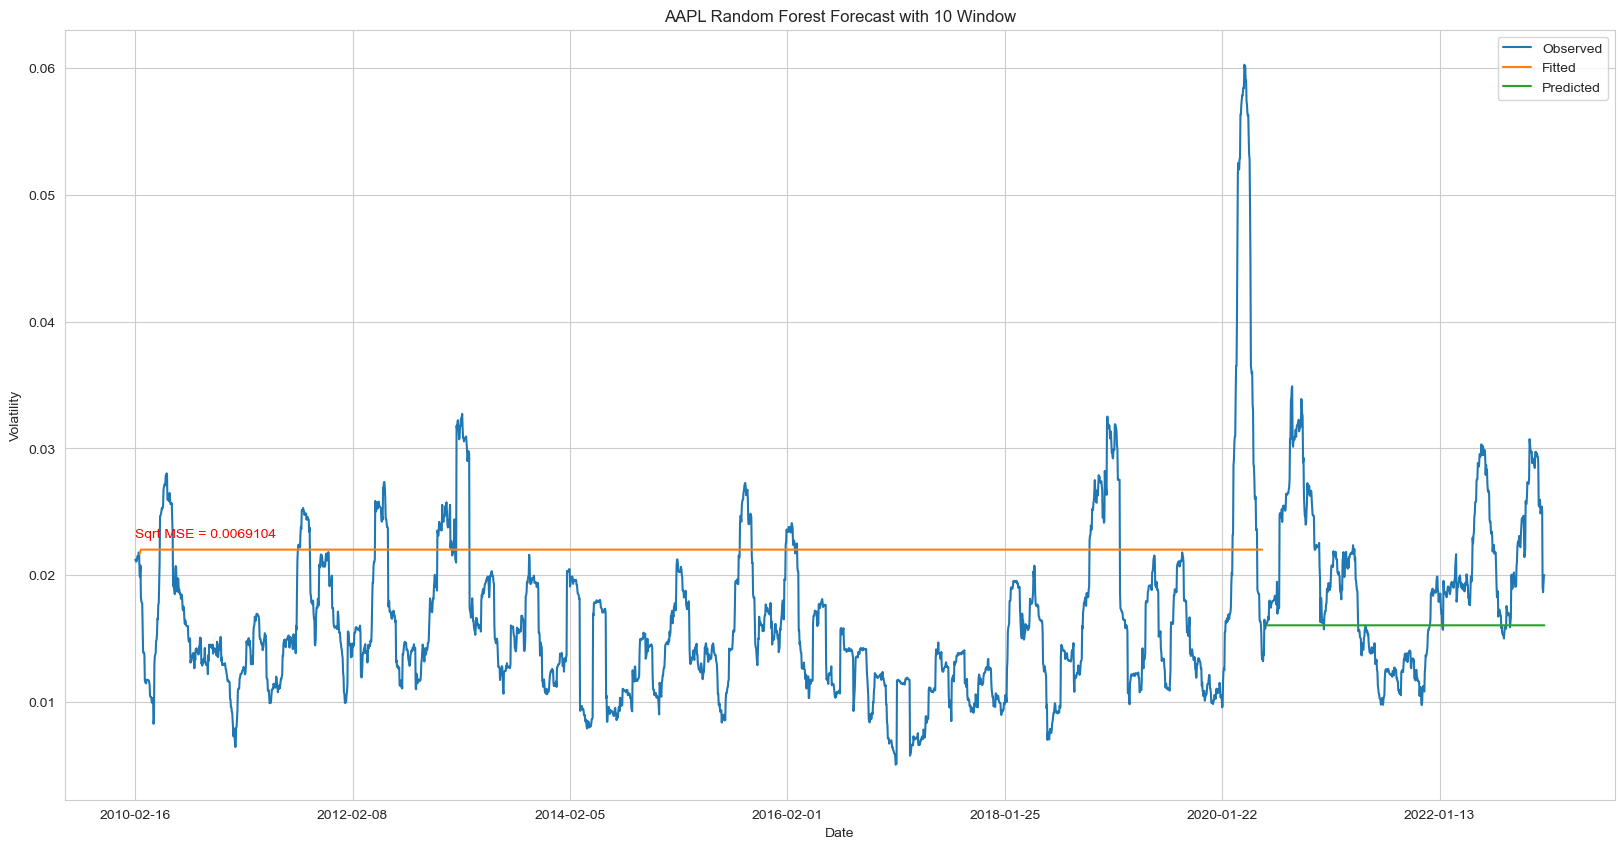

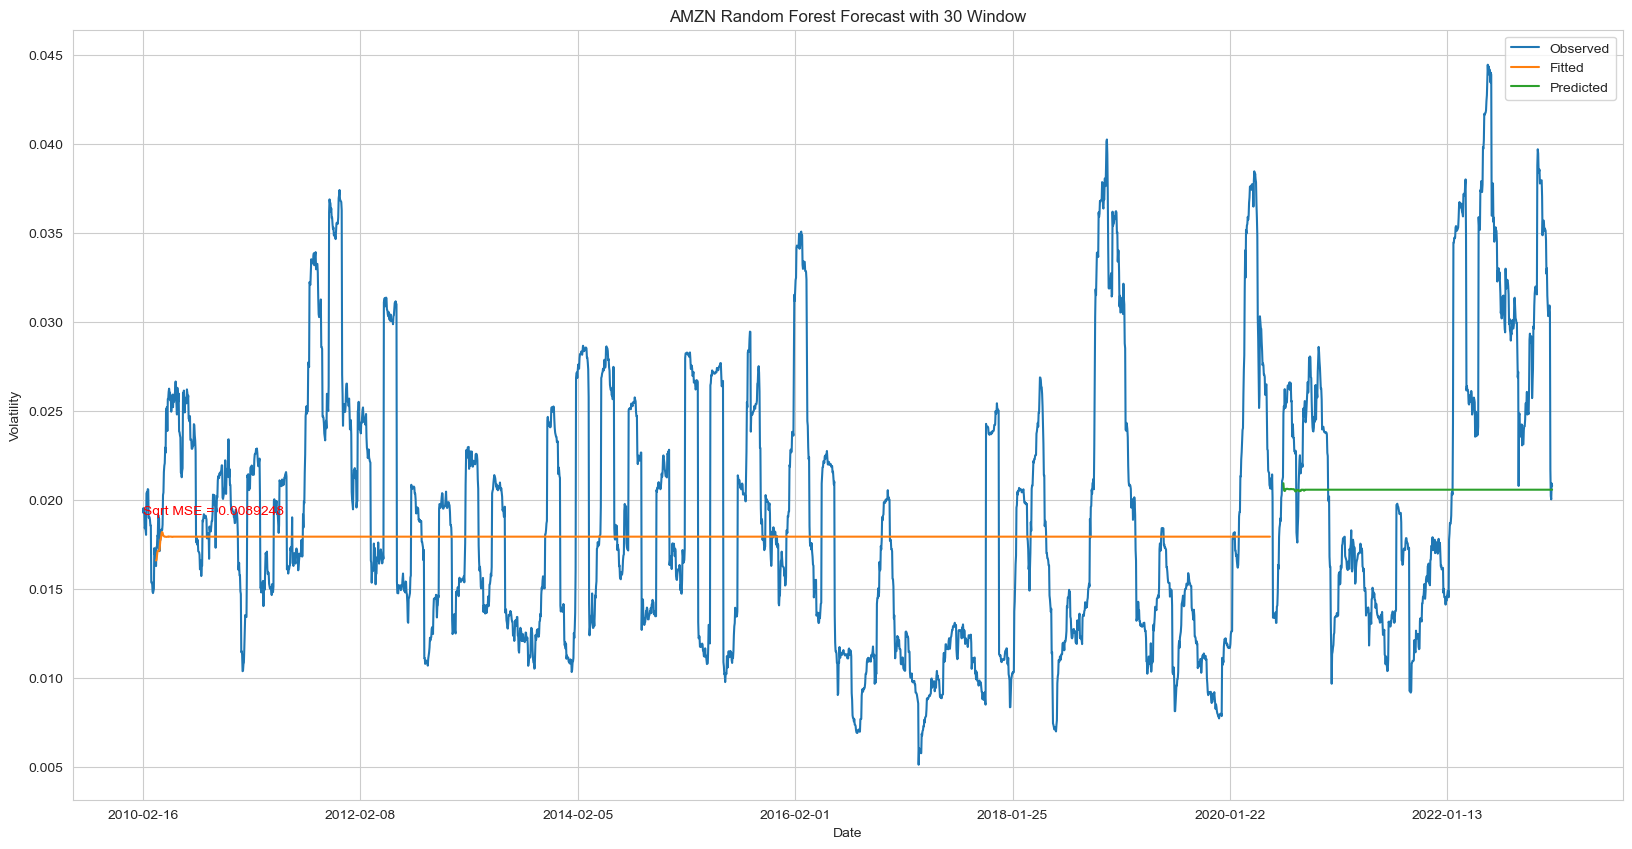

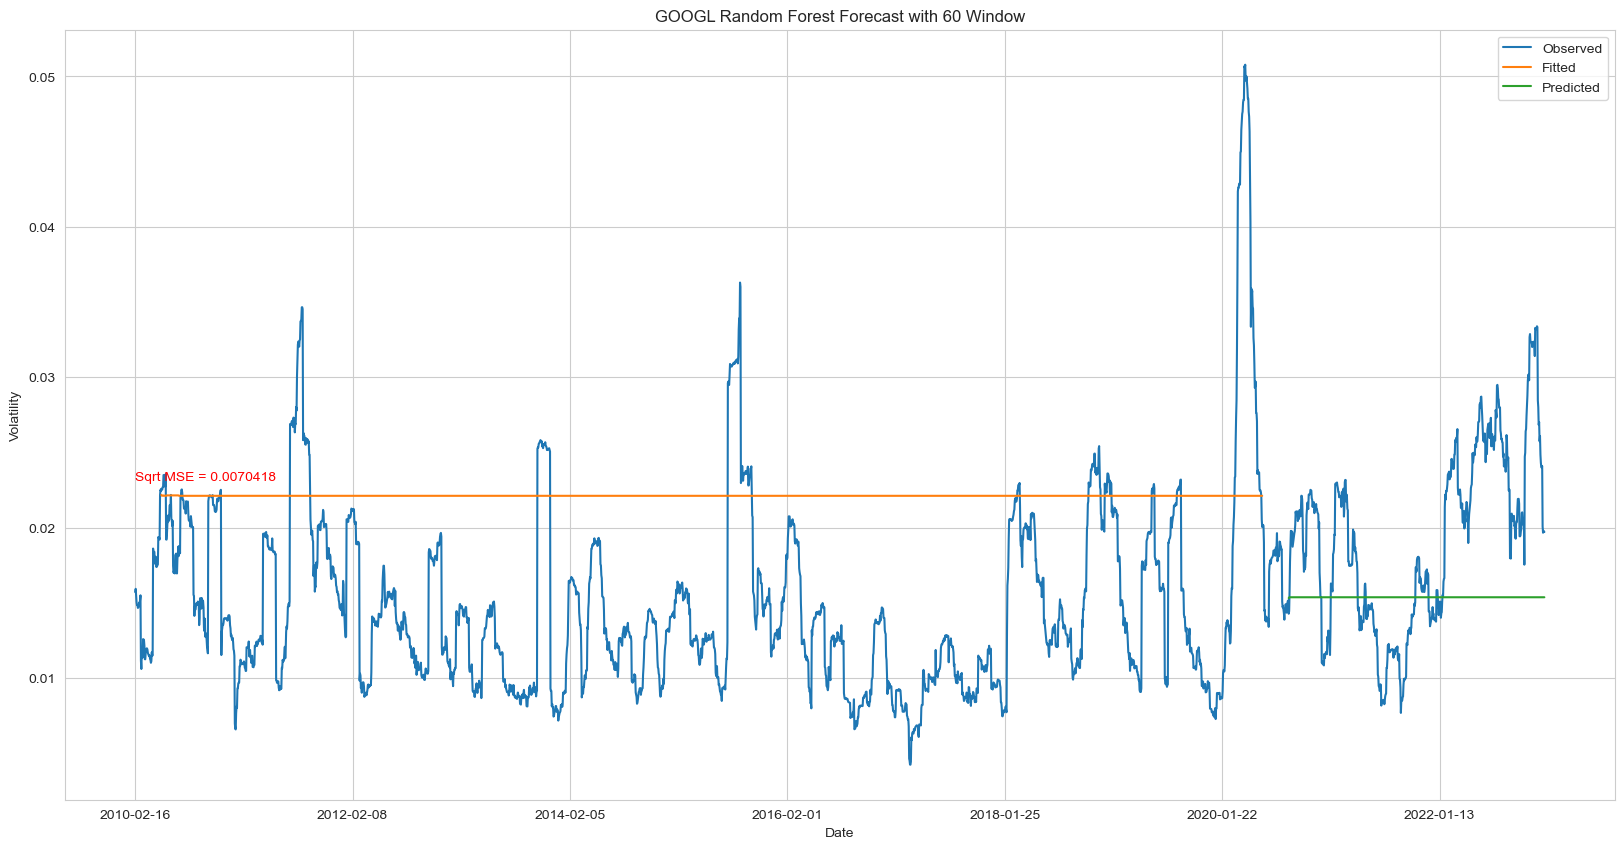

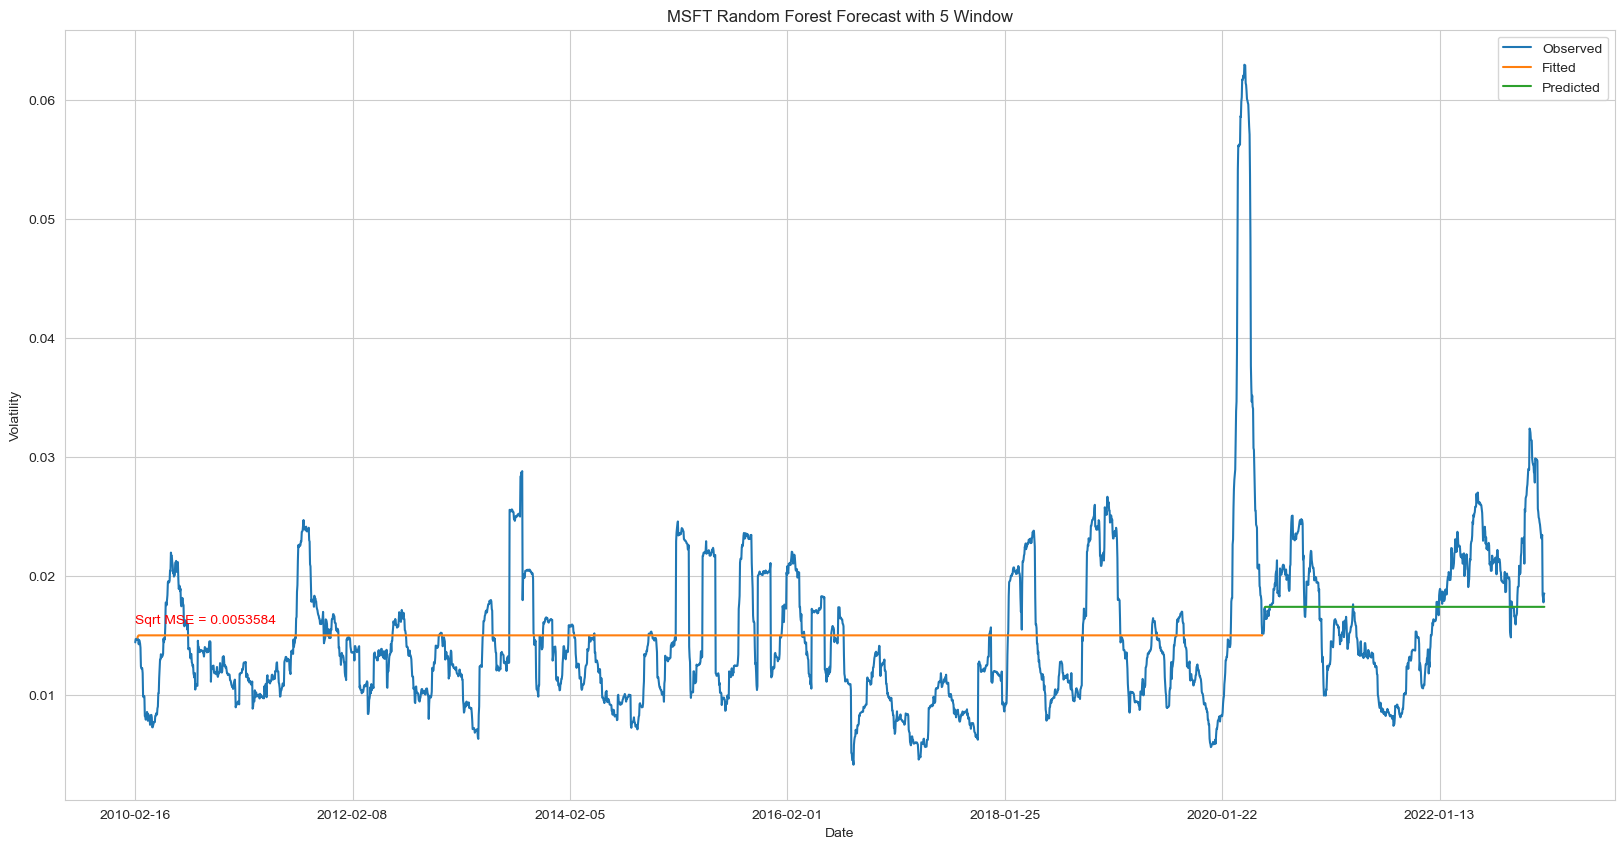

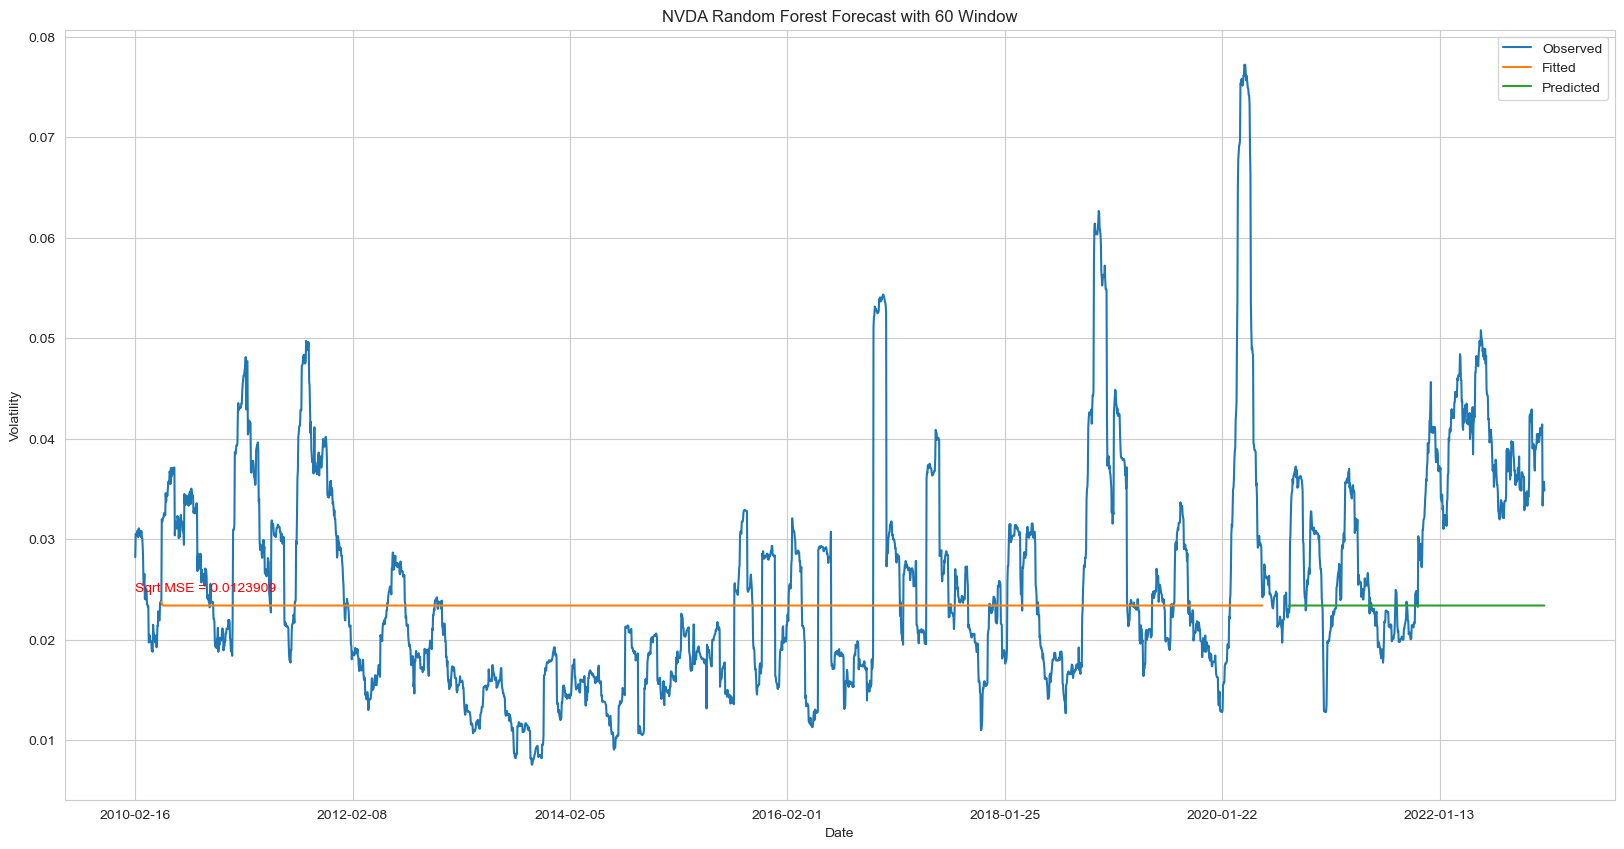

In [13]:
tech_mse = {}
for stock in tech_tickers:
    rf = tech_pred[stock]
    window = tech_windows[stock]
    X_train = np.concatenate([tech_train[f'{stock}_volatility'].shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
    X_test = np.concatenate([tech_test[f'{stock}_volatility'].shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
    fitted = rf.predict(X_train, n_windows=1)
    pred = rf.predict(X_test, n_windows=1)
    y_true = tech_test[f'{stock}_volatility'][window:]
    tech_mse[stock] = mean_squared_error(y_true, pred)

    ## make dataframes to be plotted
    obs_df = pd.DataFrame(data=tech[f"{stock}_volatility"].values,
                          index=tech.Date,
                          columns=["Observed"])

    fit_df = pd.DataFrame(data=fitted,
                          index=tech_train.Date[window:],
                          columns=["Fitted"])

    pred_df = pd.DataFrame(data=pred,
                           index=tech_test.Date[window:],
                           columns=["Predicted"])
    df = pd.concat([obs_df, fit_df, pred_df], axis=1)

    ## make the plot 
    ax = df.plot(y=["Observed", "Fitted", "Predicted"],
        figsize=(20,10),
        ylabel="Volatility",
        title=f"{stock} Random Forest Forecast with {tech_windows[stock]} Window")
    ax.text(0,df["Fitted"].max() + 0.001, f"Sqrt MSE = {round(np.sqrt(tech_mse[stock]),7)}",
            color="red")
    

print(tech_mse)


### Biotech Stocks

{'JNJ': 2.472182806257908e-07, 'LLY': 2.652973788807898e-06, 'MRK': 6.748581022105986e-07, 'NVO': 1.123397184415148e-06, 'RHHBY': 6.243336699054599e-07}


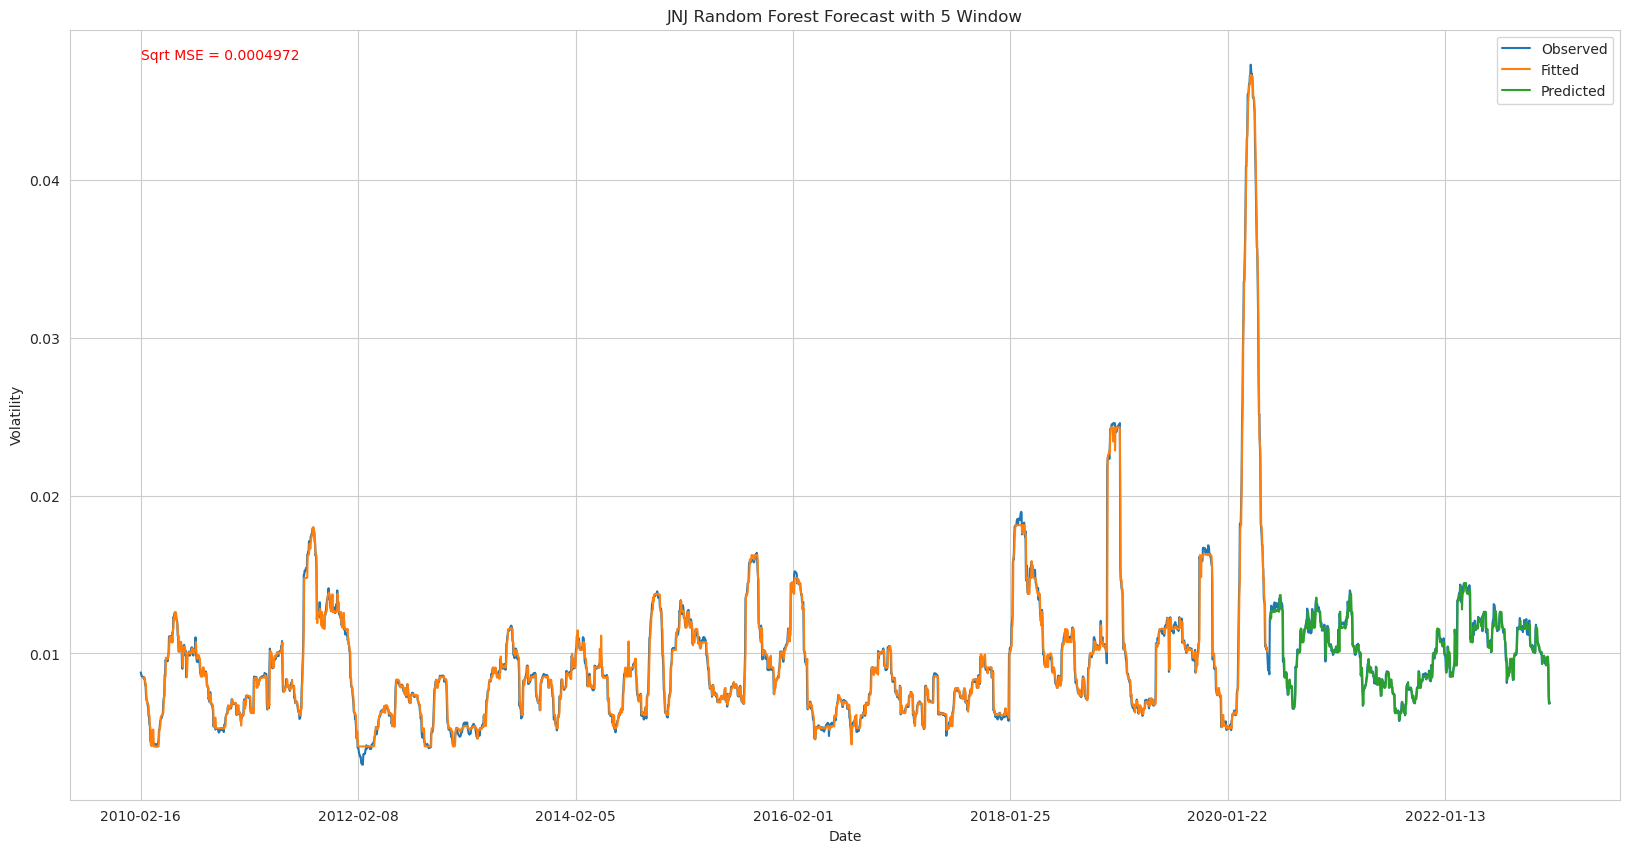

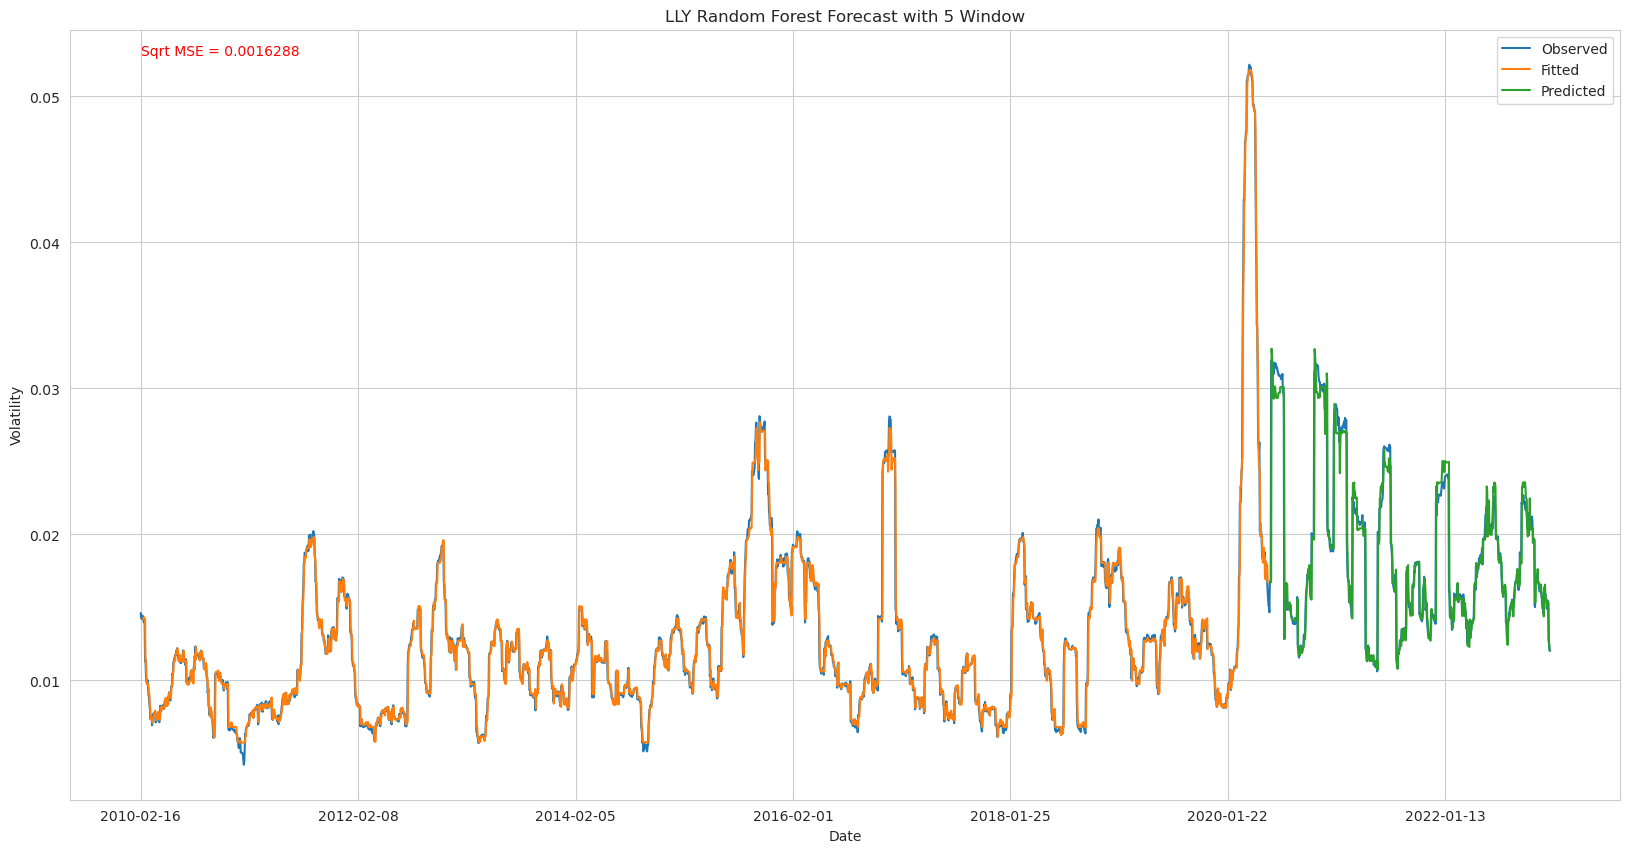

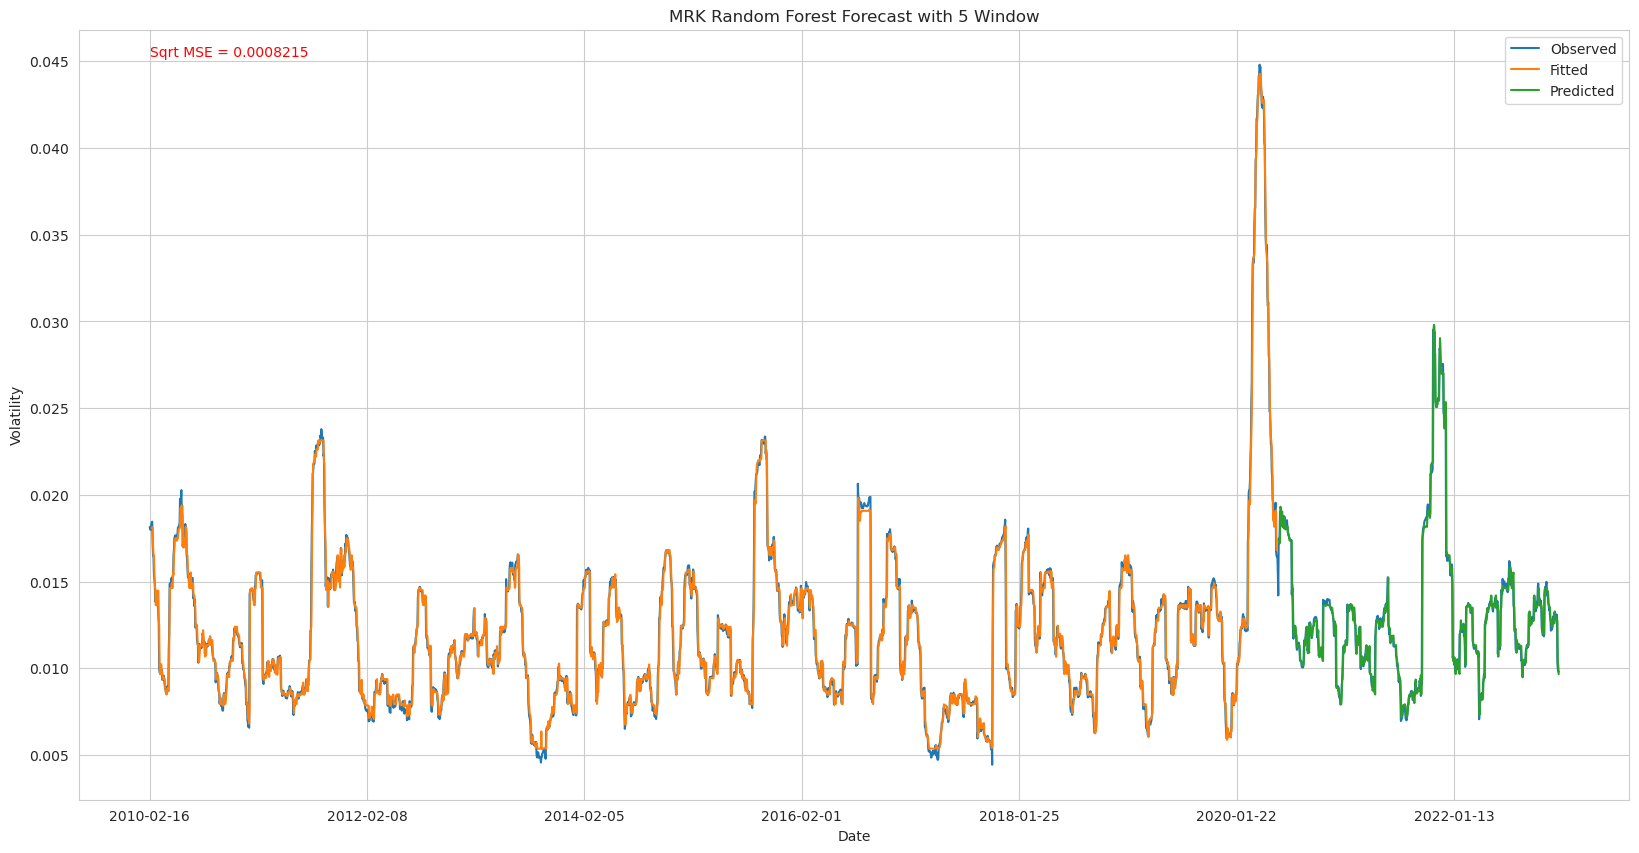

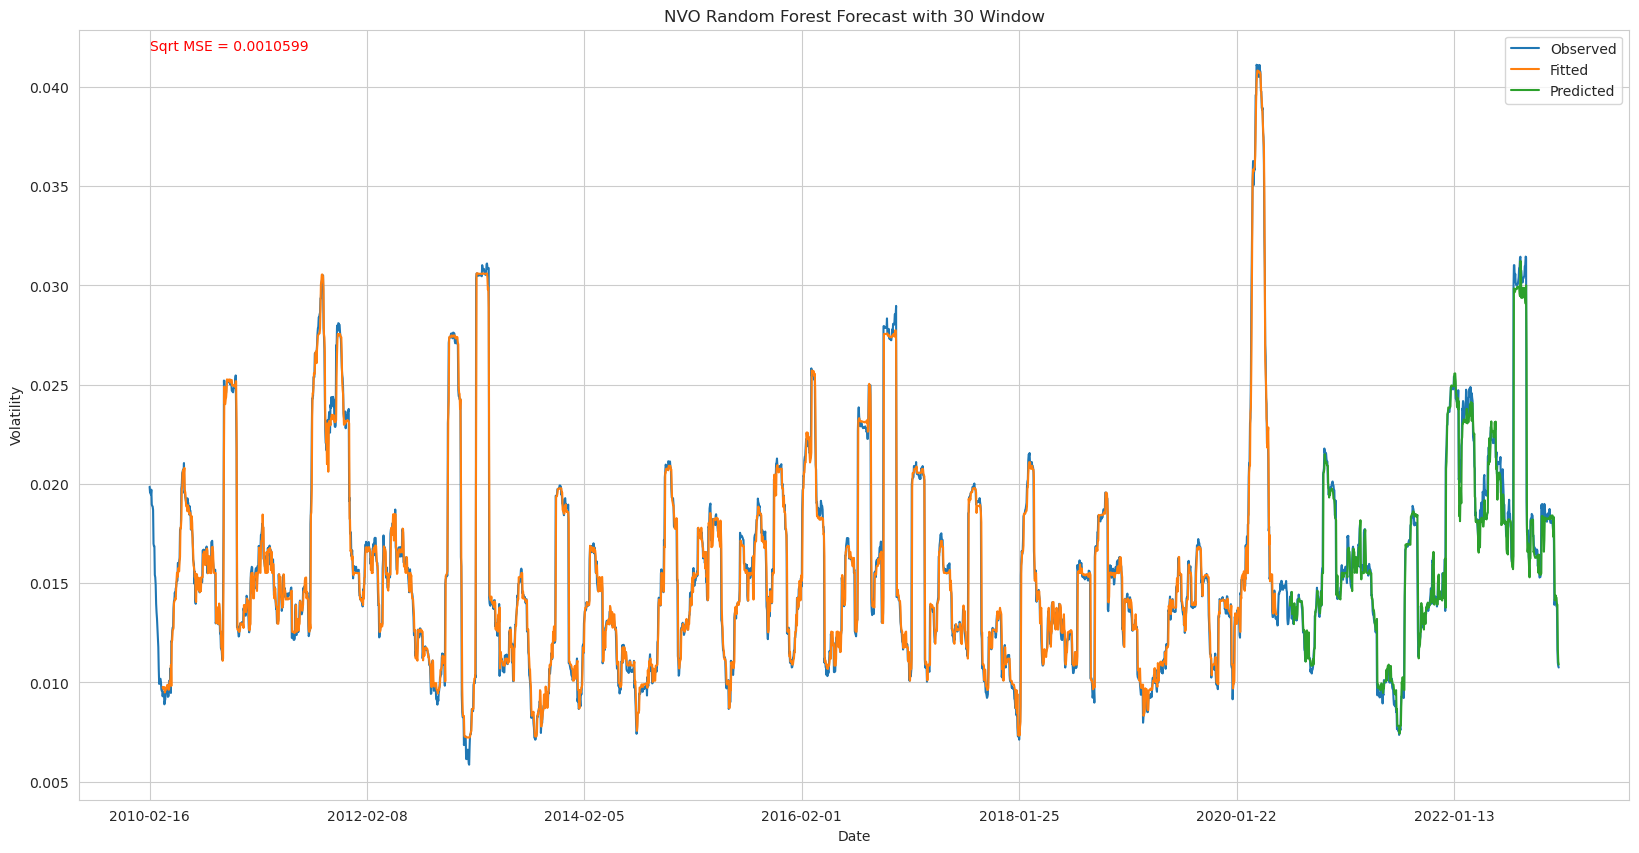

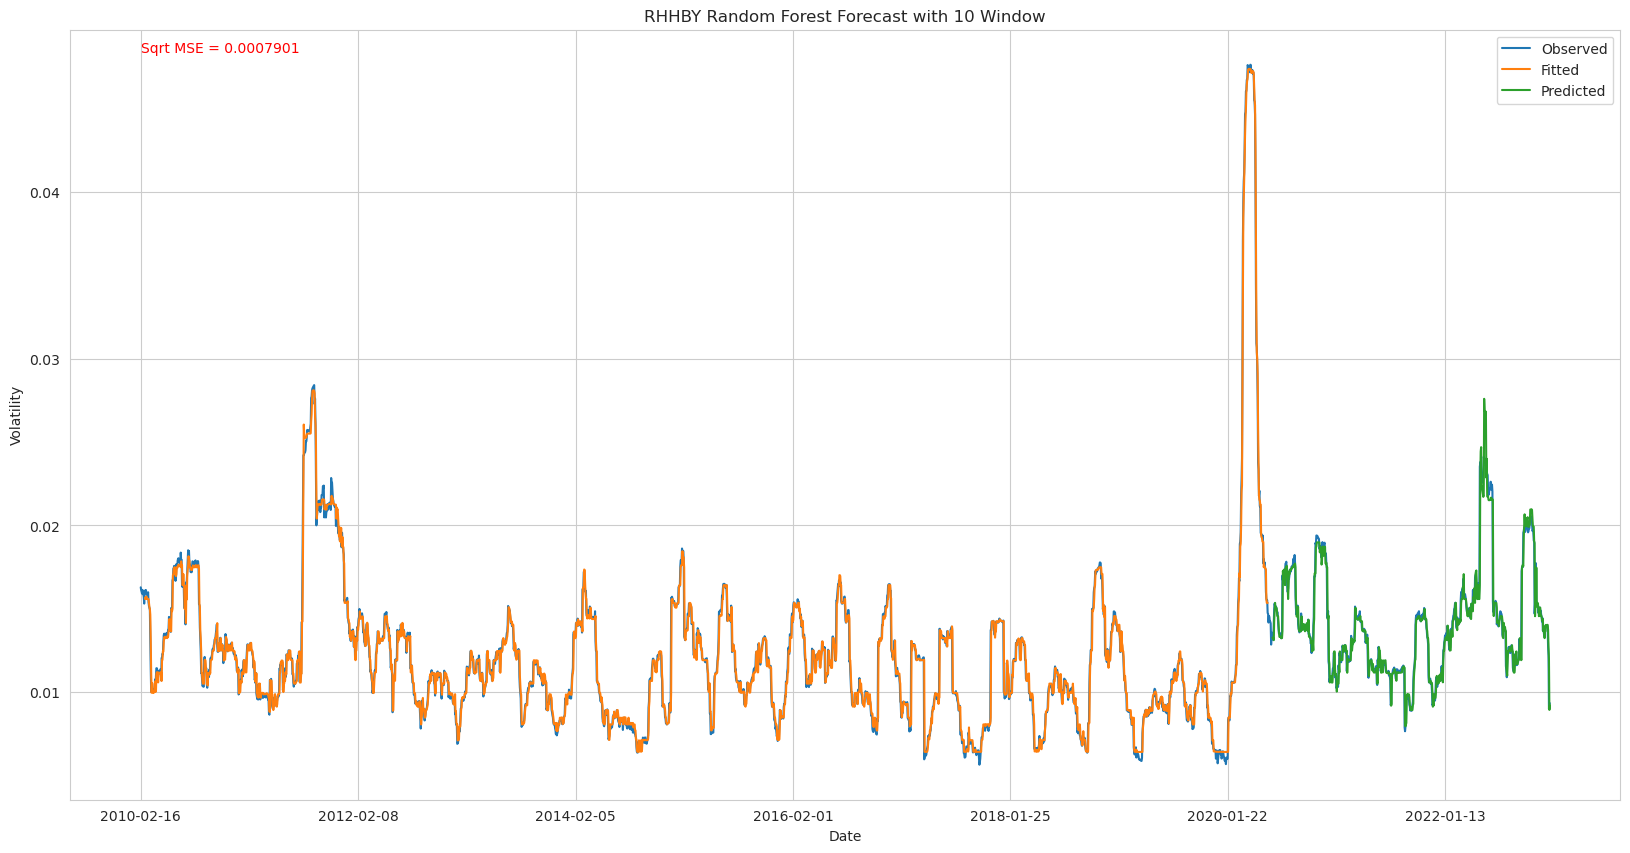

In [108]:
biotech_mse = {}
for stock in biotech_tickers:
    rf = biotech_pred[stock]
    window = biotech_windows[stock]
    X_train = np.concatenate([biotech_train[f'{stock}_volatility'].shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
    X_test = np.concatenate([biotech_test[f'{stock}_volatility'].shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
    fitted = rf.predict(X_train)
    pred = rf.predict(X_test)
    y_true = biotech_test[f'{stock}_volatility'][window:]
    biotech_mse[stock] = mean_squared_error(y_true, pred)

    ## make dataframes to be plotted
    obs_df = pd.DataFrame(data=biotech[f"{stock}_volatility"].values,
                          index=biotech.Date,
                          columns=["Observed"])

    fit_df = pd.DataFrame(data=fitted,
                          index=biotech_train.Date[window:],
                          columns=["Fitted"])

    pred_df = pd.DataFrame(data=pred,
                           index=biotech_test.Date[window:],
                           columns=["Predicted"])
    df = pd.concat([obs_df, fit_df, pred_df], axis=1)

    ## make the plot 
    ax = df.plot(y=["Observed", "Fitted", "Predicted"],
        figsize=(20,10),
        ylabel="Volatility",
        title=f"{stock} Random Forest Forecast with {biotech_windows[stock]} Window")
    ax.text(0,df["Fitted"].max() + 0.001, f"Sqrt MSE = {round(np.sqrt(biotech_mse[stock]),7)}",
            color="red")
    

print(biotech_mse)

### Healthcare Stocks

{'AMGN': 8.114811326312261e-07, 'CVS': 1.0077935489026767e-06, 'ELV': 9.698584590871097e-07, 'PFE': 8.777521485332633e-07, 'UNH': 6.706780038241676e-07}


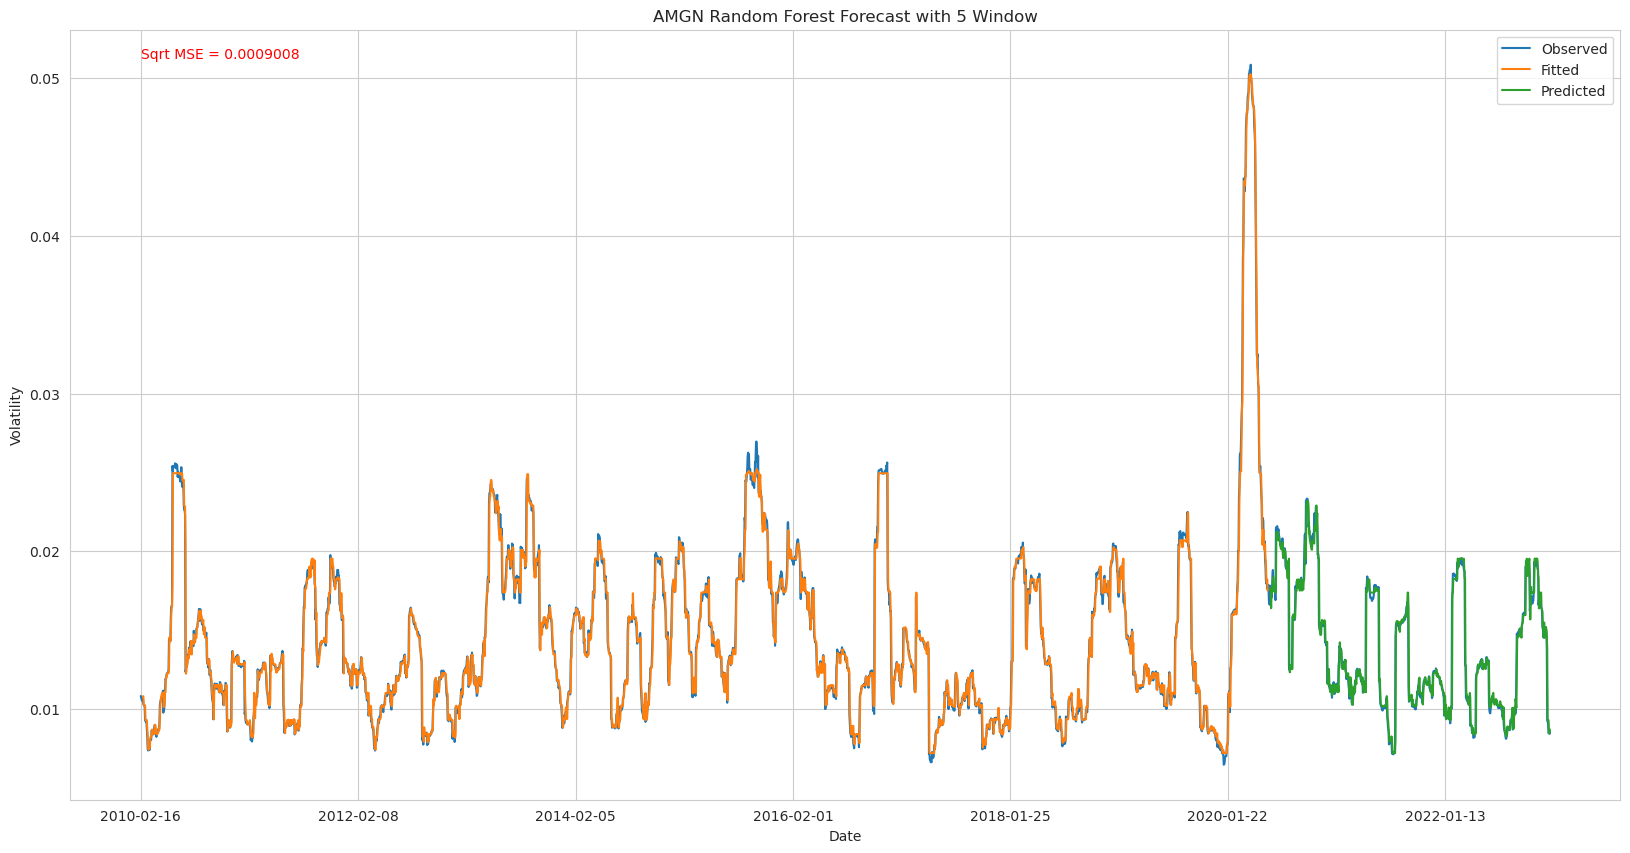

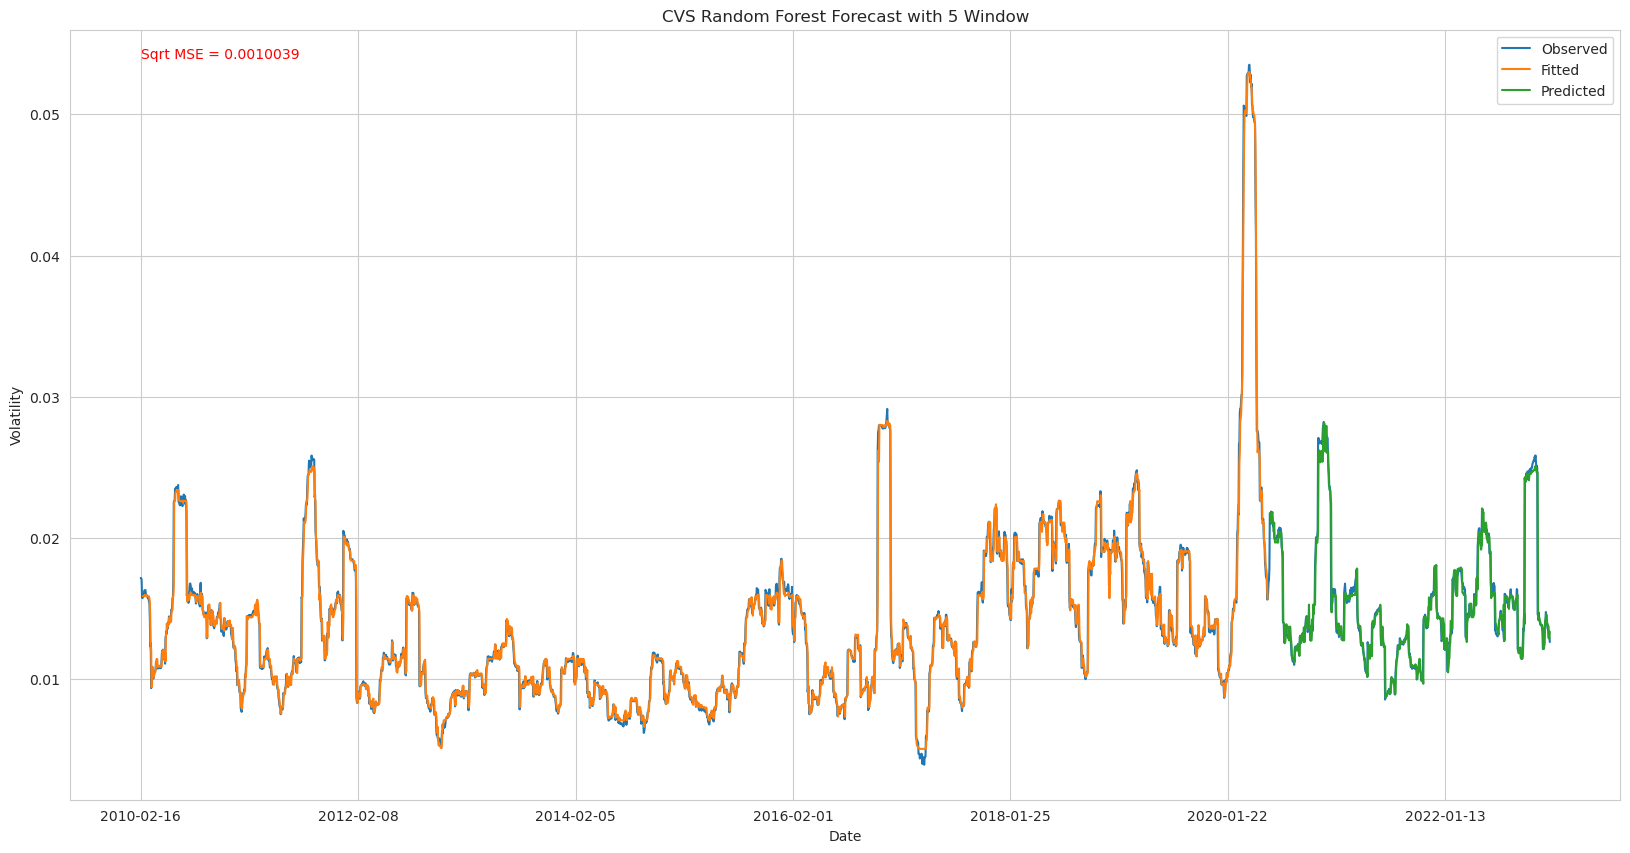

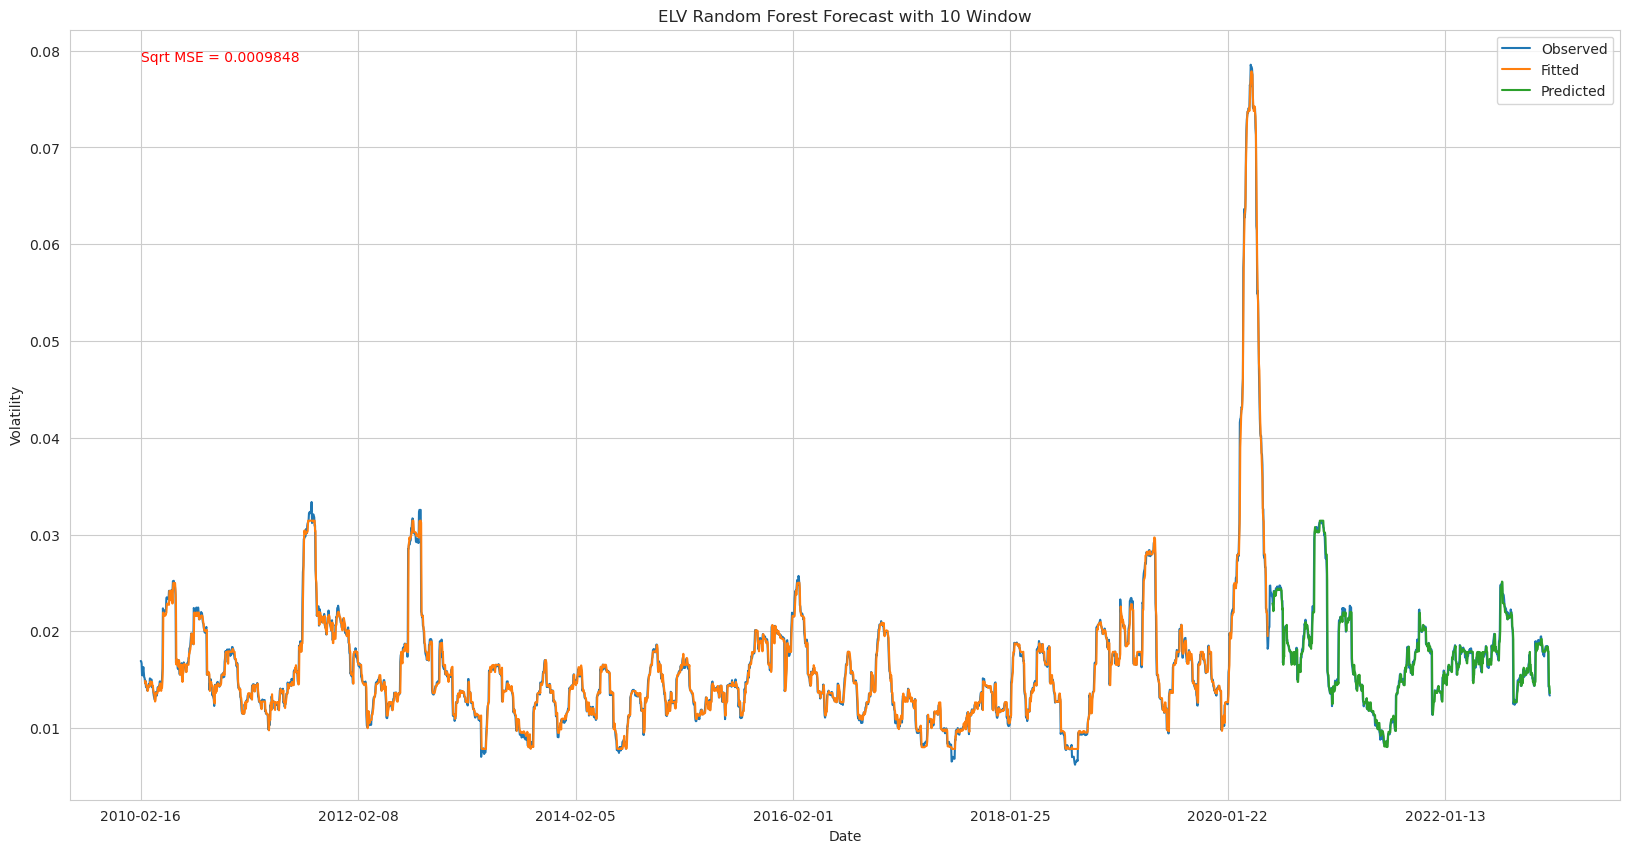

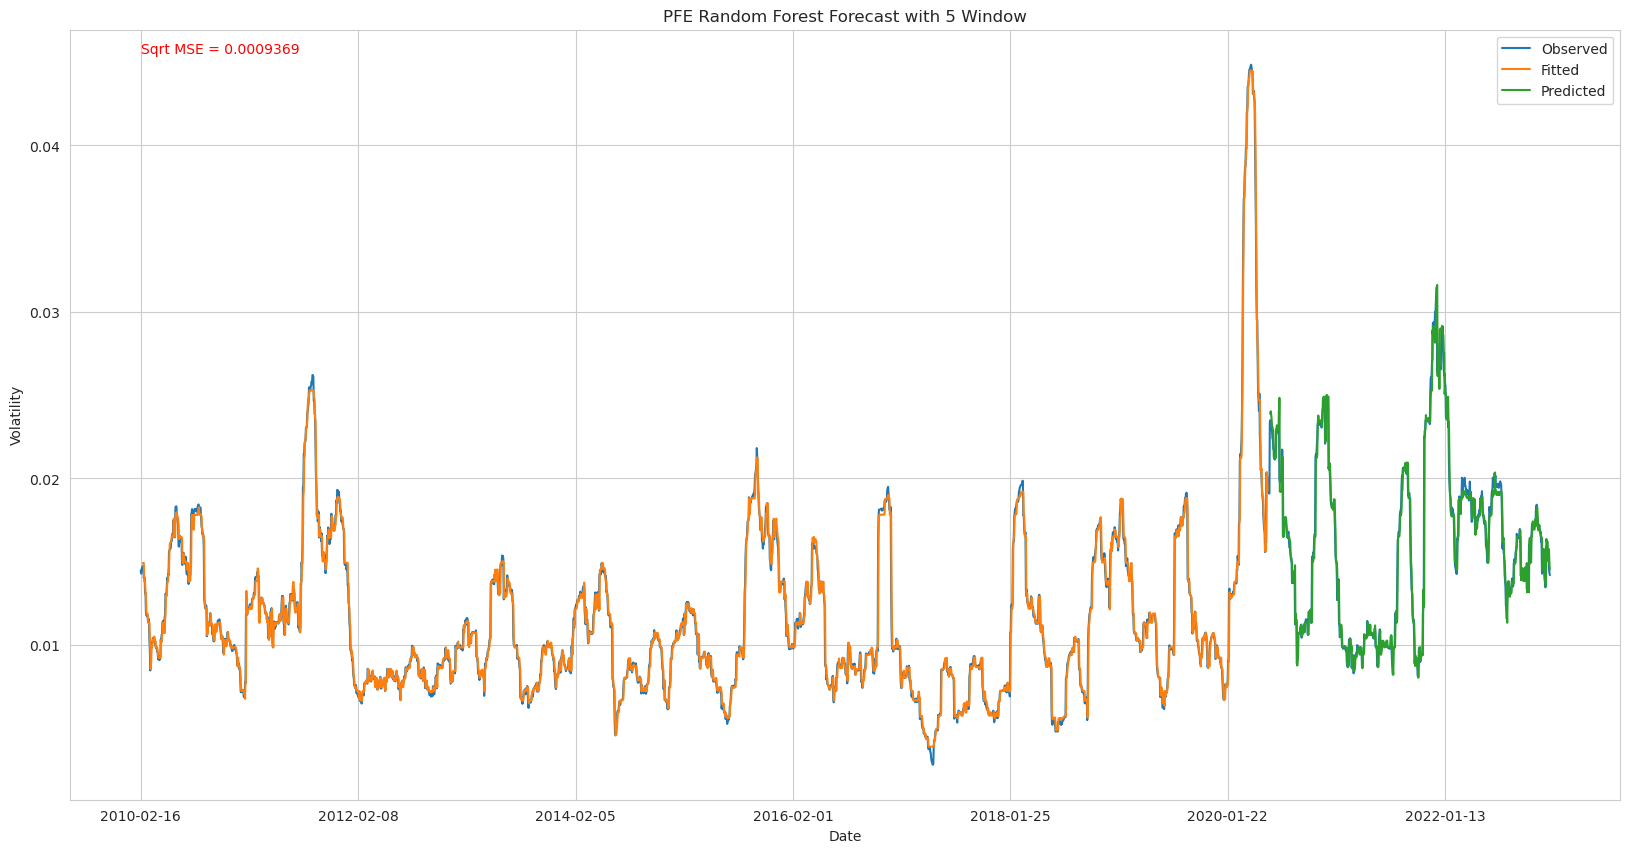

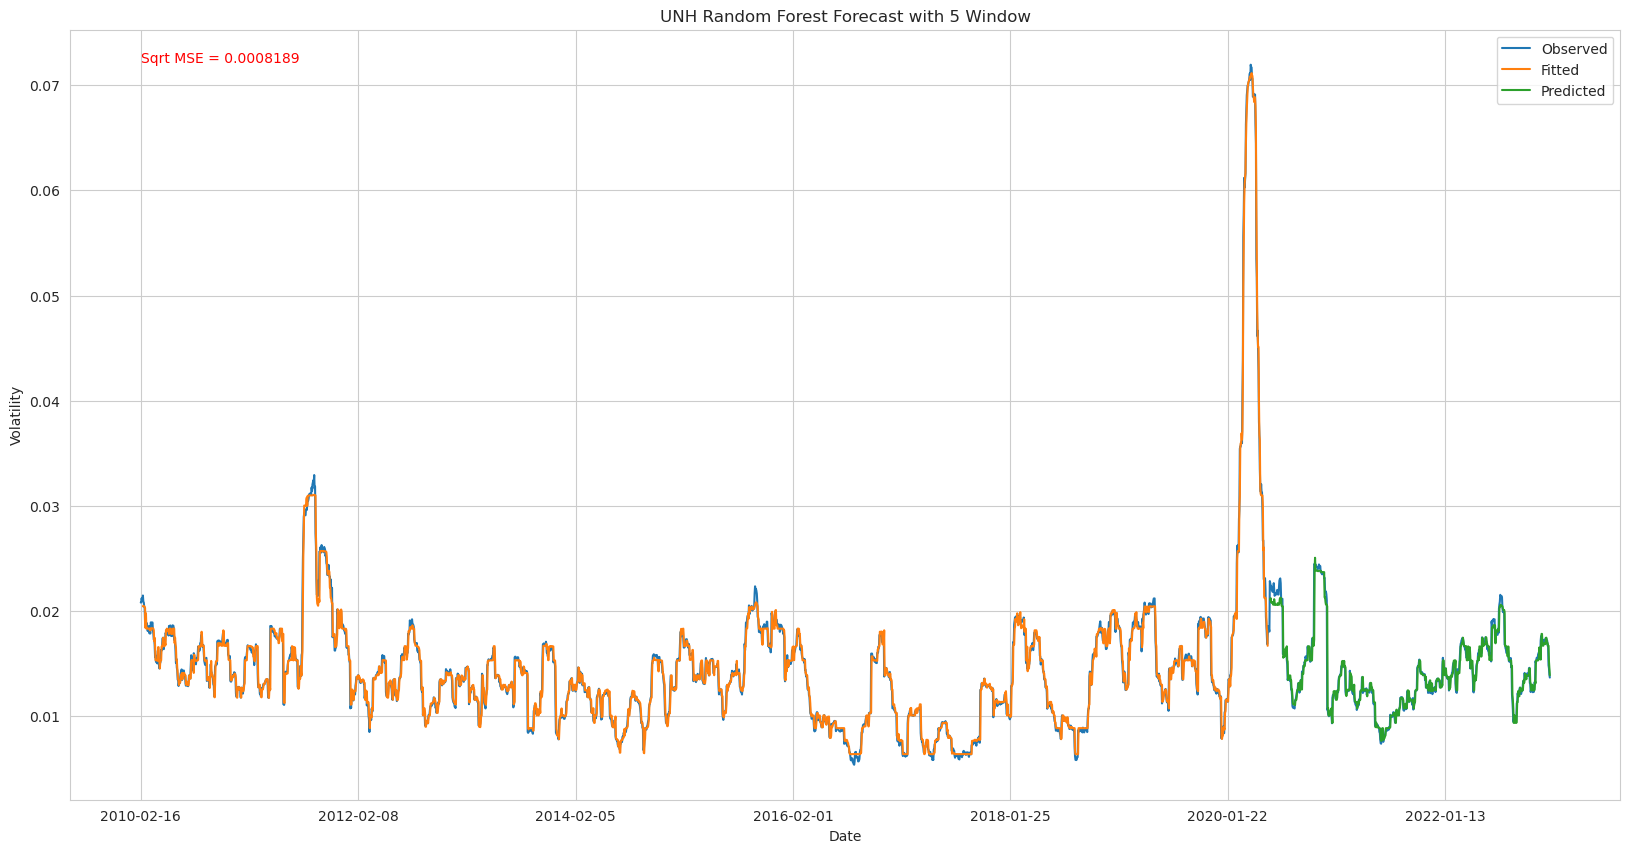

In [109]:
healthcare_mse = {}
for stock in healthcare_tickers:
    rf = healthcare_pred[stock]
    window = healthcare_windows[stock]
    X_train = np.concatenate([healthcare_train[f'{stock}_volatility'].shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
    X_test = np.concatenate([healthcare_test[f'{stock}_volatility'].shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
    fitted = rf.predict(X_train)
    pred = rf.predict(X_test)
    y_true = healthcare_test[f'{stock}_volatility'][window:]
    healthcare_mse[stock] = mean_squared_error(y_true, pred)

    ## make dataframes to be plotted
    obs_df = pd.DataFrame(data=healthcare[f"{stock}_volatility"].values,
                          index=healthcare.Date,
                          columns=["Observed"])

    fit_df = pd.DataFrame(data=fitted,
                          index=healthcare_train.Date[window:],
                          columns=["Fitted"])

    pred_df = pd.DataFrame(data=pred,
                           index=healthcare_test.Date[window:],
                           columns=["Predicted"])
    df = pd.concat([obs_df, fit_df, pred_df], axis=1)

    ## make the plot 
    ax = df.plot(y=["Observed", "Fitted", "Predicted"],
        figsize=(20,10),
        ylabel="Volatility",
        title=f"{stock} Random Forest Forecast with {healthcare_windows[stock]} Window")
    ax.text(0,df["Fitted"].max() + 0.001, f"Sqrt MSE = {round(np.sqrt(healthcare_mse[stock]),7)}",
            color="red")
    

print(healthcare_mse)

### Industrial Stocks

{'F': 2.2806917007152922e-06, 'GE': 1.5124393826792154e-06, 'NEE': 9.495772191630609e-07, 'SO': 4.7757277497165e-07, 'UNP': 4.549713682757603e-07}


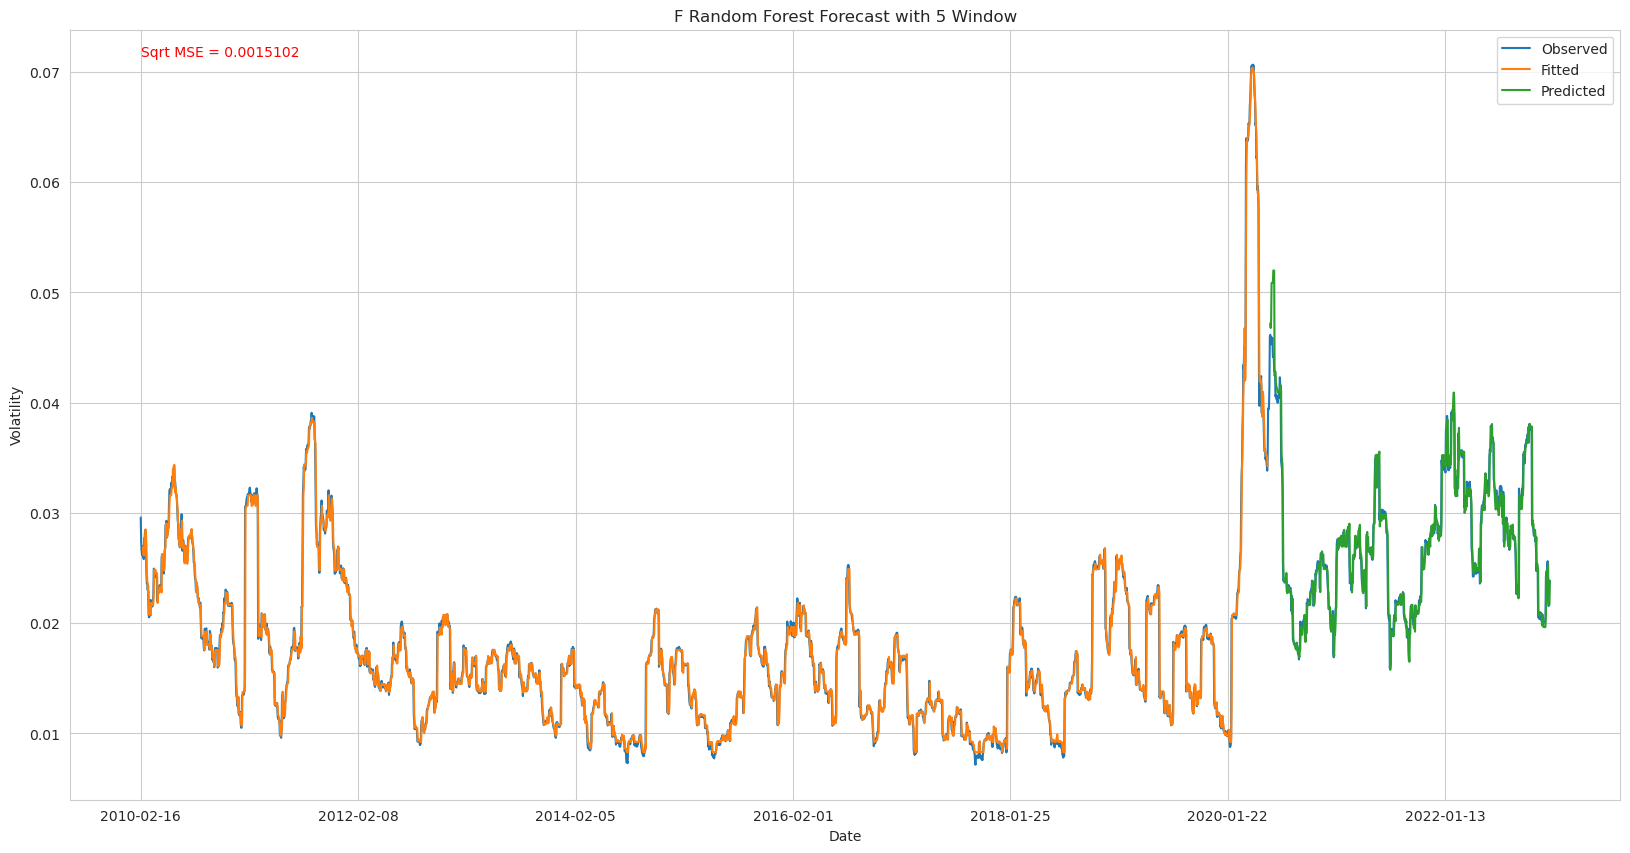

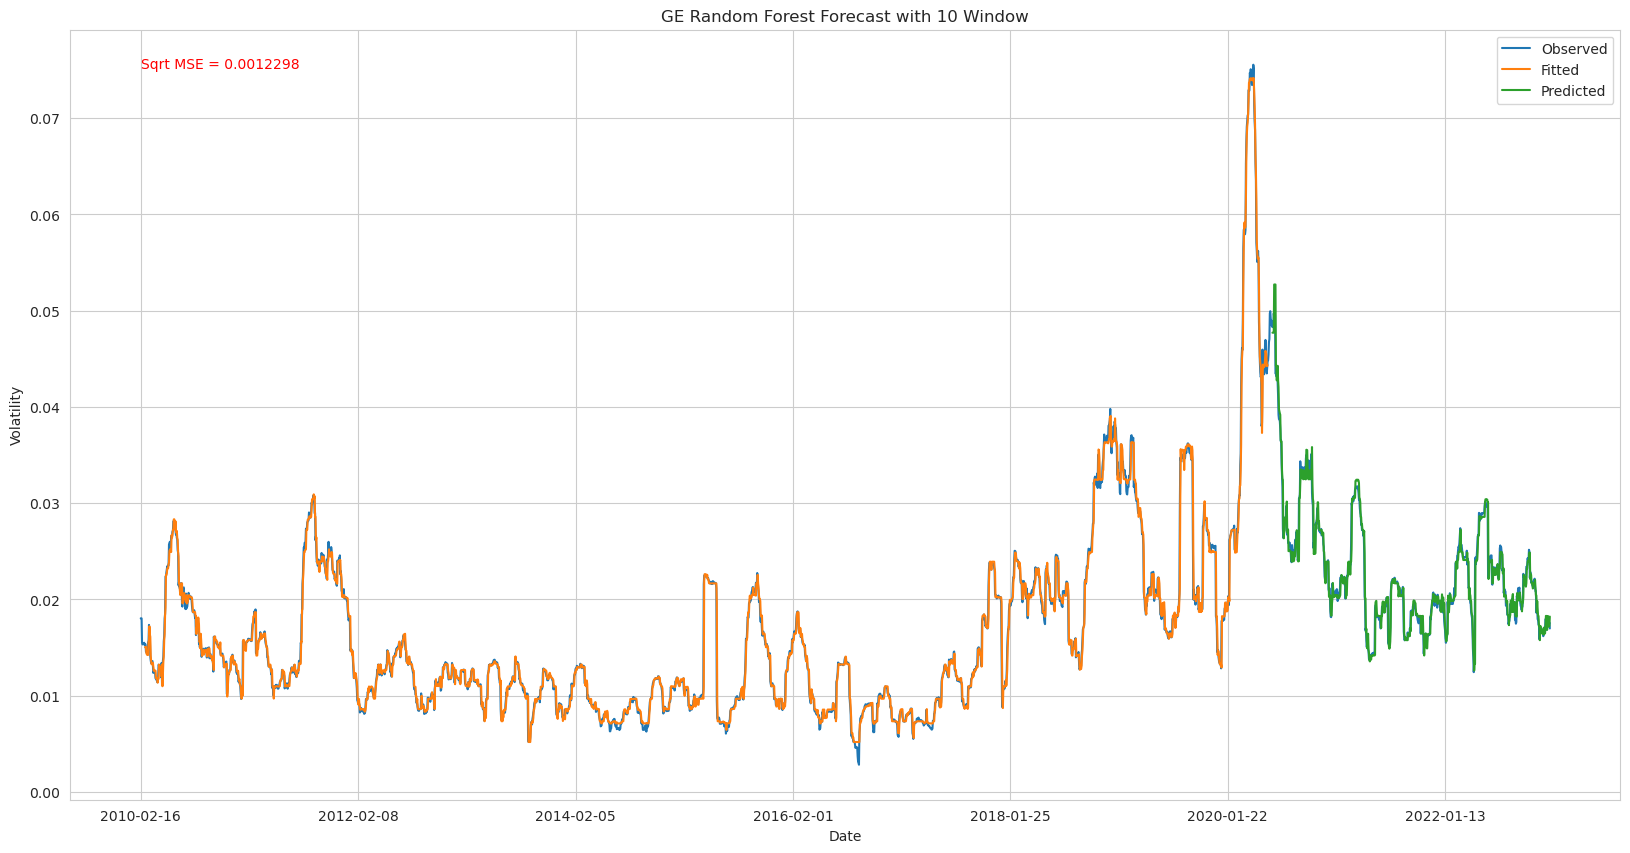

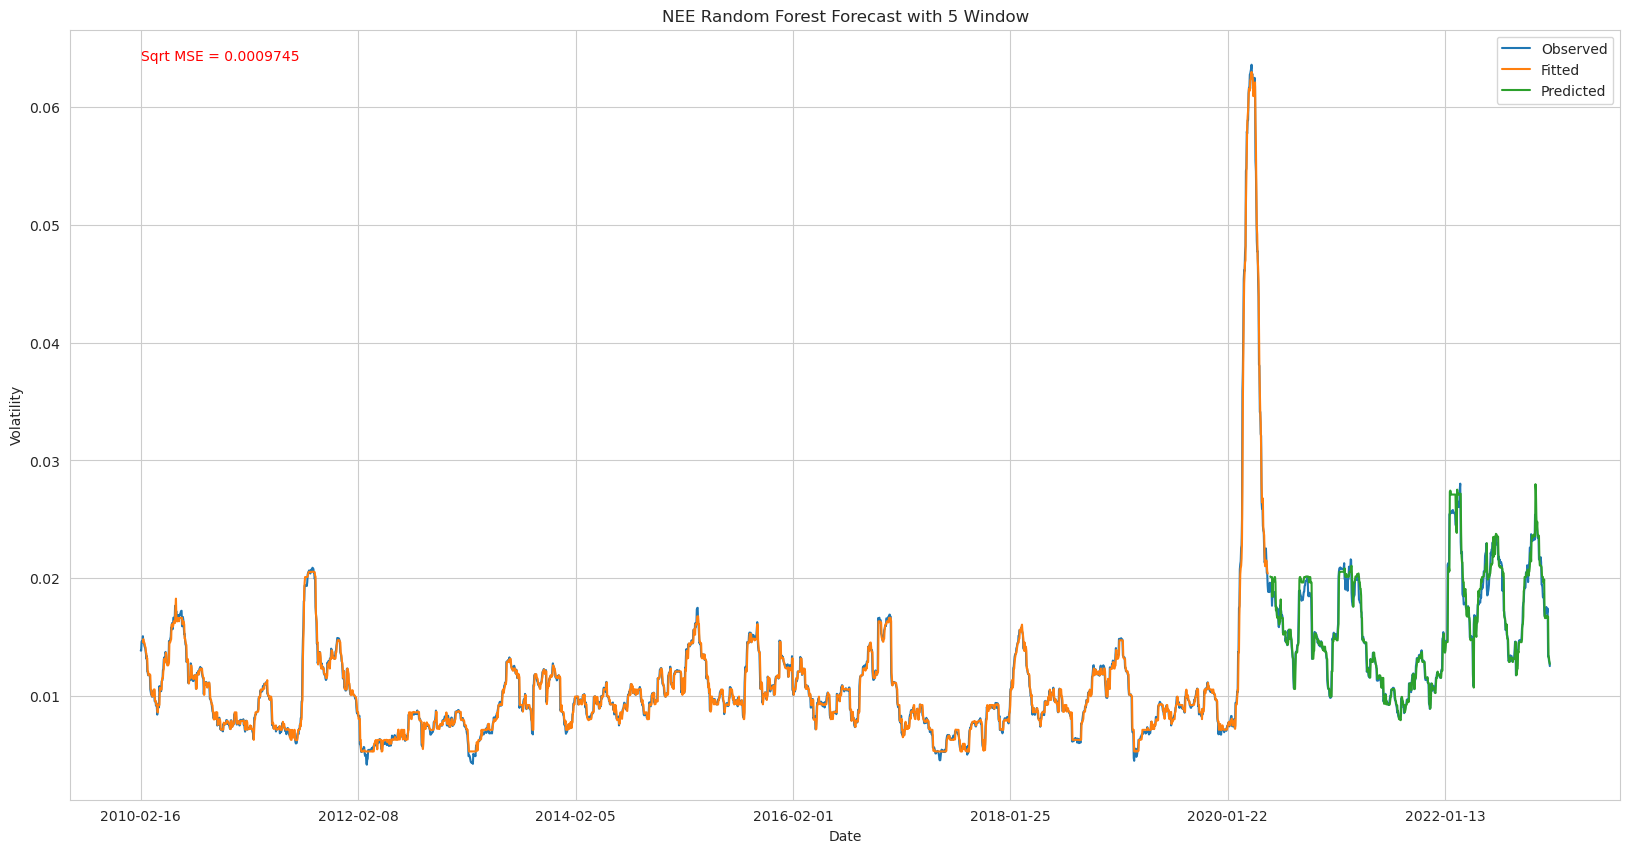

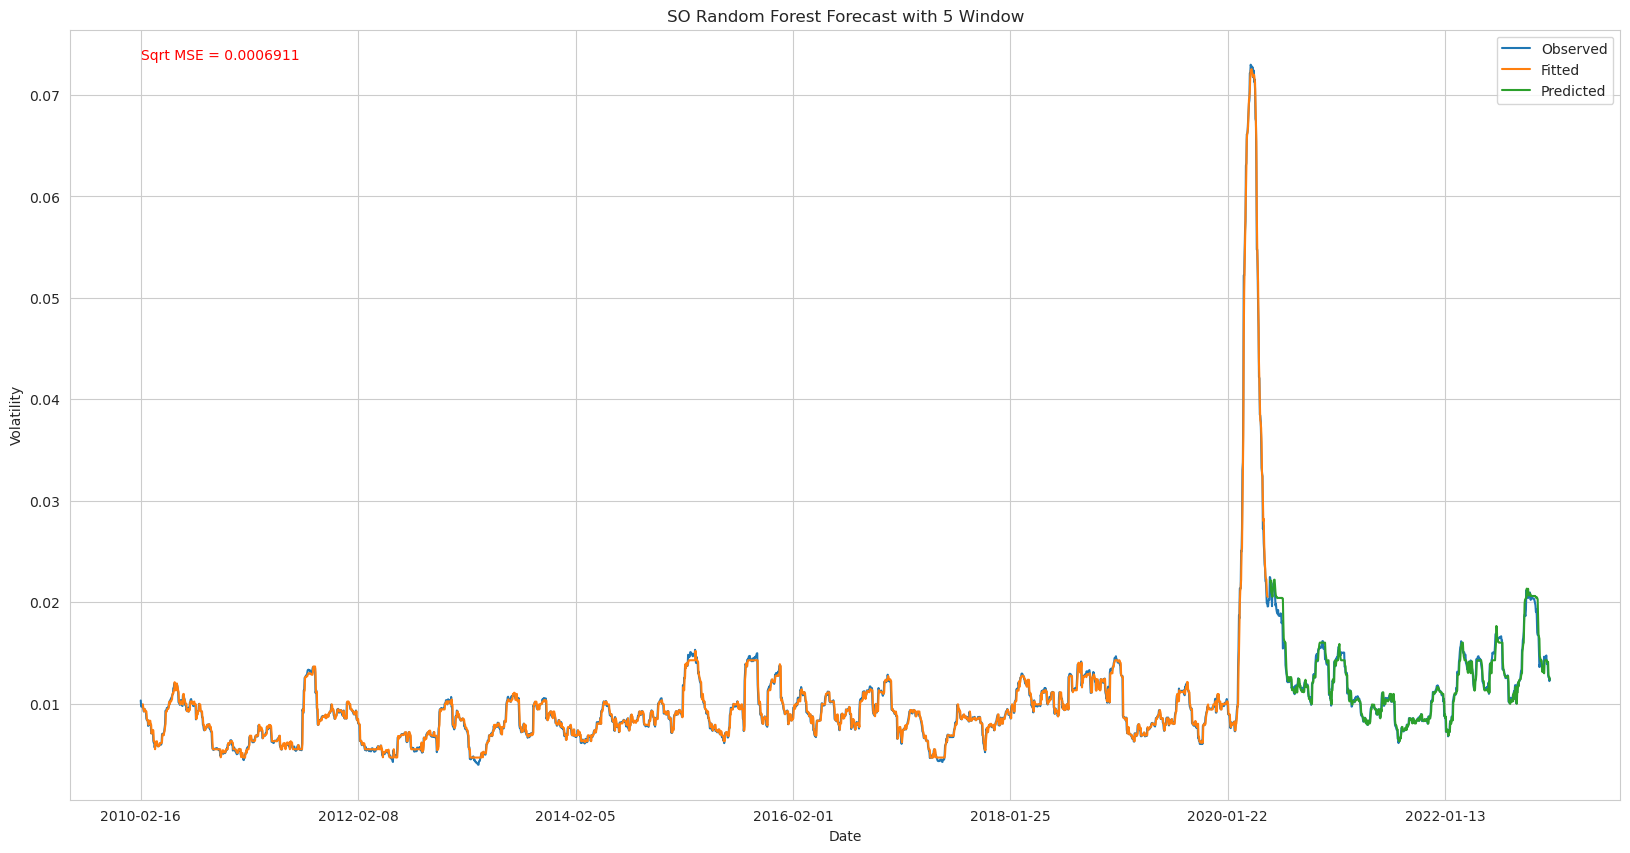

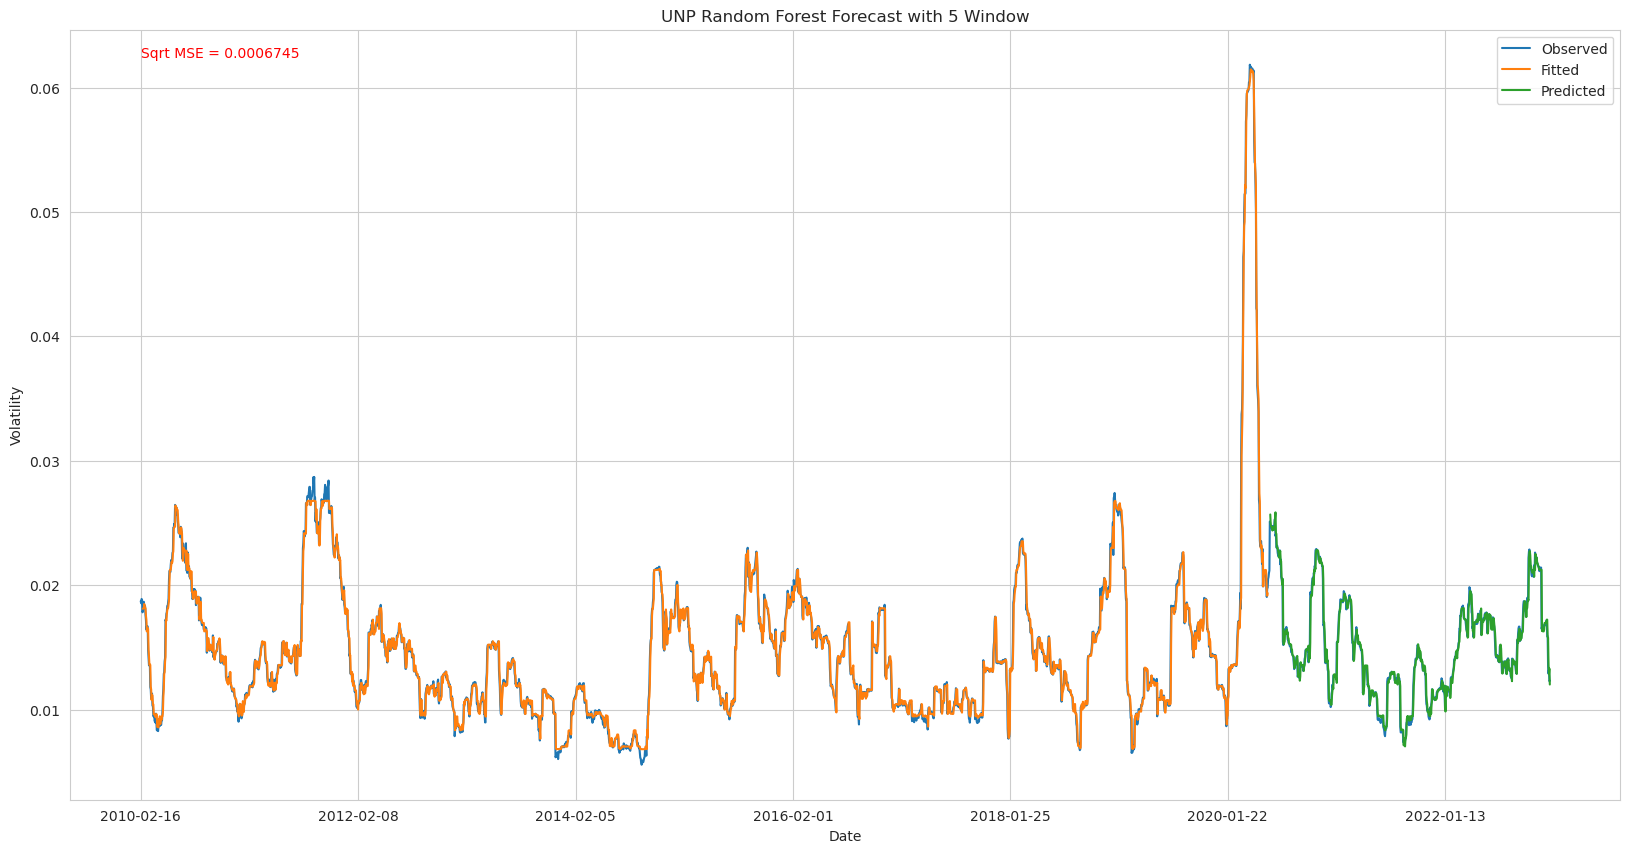

In [110]:
industrial_mse = {}
for stock in industrial_tickers:
    rf = industrial_pred[stock]
    window = industrial_windows[stock]
    X_train = np.concatenate([industrial_train[f'{stock}_volatility'].shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
    X_test = np.concatenate([industrial_test[f'{stock}_volatility'].shift(t).values.reshape(-1,1) for t in range(1,window+1)],
                                     axis=1)[window:]
    fitted = rf.predict(X_train)
    pred = rf.predict(X_test)
    y_true = industrial_test[f'{stock}_volatility'][window:]
    industrial_mse[stock] = mean_squared_error(y_true, pred)

    ## make dataframes to be plotted
    obs_df = pd.DataFrame(data=industrial[f"{stock}_volatility"].values,
                          index=industrial.Date,
                          columns=["Observed"])

    fit_df = pd.DataFrame(data=fitted,
                          index=industrial_train.Date[window:],
                          columns=["Fitted"])

    pred_df = pd.DataFrame(data=pred,
                           index=industrial_test.Date[window:],
                           columns=["Predicted"])
    df = pd.concat([obs_df, fit_df, pred_df], axis=1)

    ## make the plot 
    ax = df.plot(y=["Observed", "Fitted", "Predicted"],
        figsize=(20,10),
        ylabel="Volatility",
        title=f"{stock} Random Forest Forecast with {industrial_windows[stock]} Window")
    ax.text(0,df["Fitted"].max() + 0.001, f"Sqrt MSE = {round(np.sqrt(industrial_mse[stock]),7)}",
            color="red")
    

print(industrial_mse)

***
## Conclusion 

Here we collect some conclusions regarding the random forest predictions. 

### Best Performance on Stock

In [120]:
## merge dictionaries
all_mses = tech_mse | biotech_mse | healthcare_mse | industrial_mse

best_performing_stock = [k for k in all_mses if all_mses[k] == min(all_mses.values())][0]

print(f"The Random Forest Regressor modelled {best_performing_stock} the best, with the smallest Sqrt MSE of {np.sqrt(all_mses[best_performing_stock])}")

The Random Forest Regressor modelled JNJ the best, with the smallest Sqrt MSE of 0.0004972104993117008


### Best Performance by Industry Sector

In [121]:
best_performing_stock = [k for k in tech_mse if tech_mse[k] == min(tech_mse.values())][0]
print(f"TECH: RFR performed best on {best_performing_stock} with the smallest Sqrt MSE of {np.sqrt(tech_mse[best_performing_stock])}")

best_performing_stock = [k for k in biotech_mse if biotech_mse[k] == min(biotech_mse.values())][0]
print(f"BIOTECH: RFR performed best on {best_performing_stock} with the smallest Sqrt MSE of {np.sqrt(biotech_mse[best_performing_stock])}")

best_performing_stock = [k for k in healthcare_mse if healthcare_mse[k] == min(healthcare_mse.values())][0]
print(f"HEALTHCARE: RFR performed best on {best_performing_stock} with the smallest Sqrt MSE of {np.sqrt(healthcare_mse[best_performing_stock])}")

best_performing_stock = [k for k in industrial_mse if industrial_mse[k] == min(industrial_mse.values())][0]
print(f"INDUSTRIAL: RFR performed best on {best_performing_stock} with the smallest Sqrt MSE of {np.sqrt(industrial_mse[best_performing_stock])}")

TECH: RFR performed best on MSFT with the smallest Sqrt MSE of 0.0008166328902053728
BIOTECH: RFR performed best on JNJ with the smallest Sqrt MSE of 0.0004972104993117008
HEALTHCARE: RFR performed best on UNH with the smallest Sqrt MSE of 0.0008189493292165075
INDUSTRIAL: RFR performed best on UNP with the smallest Sqrt MSE of 0.0006745156545816859


### Best Performing Industry Sector

In [127]:
sect_avg = {}
sect_avg['tech'] = np.mean(list(tech_mse.values()))
sect_avg['biotech'] = np.mean(list(biotech_mse.values()))
sect_avg['healthcare'] = np.mean(list(healthcare_mse.values()))
sect_avg['industrial'] = np.mean(list(industrial_mse.values()))

best_performing_sector = [k for k in sect_avg if sect_avg[k] == min(sect_avg.values())][0]

print(f"RFR performed best on the {best_performing_sector} sector stocks with an average sqrt MSE of {np.sqrt(sect_avg[best_performing_sector])}.")

RFR performed best on the healthcare sector stocks with an average sqrt MSE of 0.0009314035959752833.
